In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import re
import itertools

# Visualization libraries
import matplotlib.pyplot as plt

# Project libraries
# set path to local modules and submodules
import sys, os
sys.path.append(os.path.abspath("src")) # add src folder to path
# import local modules and submodules
import data_ravers_utils.file_handler as fl
import data_ravers_utils.eda_utils as eda

# Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings


# Logging
import logging
# setup logging level
logging.getLogger().setLevel(logging.INFO)

# EDA start

Bandcamp sales dataset contains 1,000,000 items from Bandcamp's sales feed between 9/9/2020 and 10/2/2020.

- _id: unique identifier combining the sale's URL and UTC timestamp.
- url: the path to the item on Bandcamp. Use this column to join this dataset to the dataset of Bandcamp items.
- artist_name: Name of the artist.
- album_title: Title of the album, if applicable.
- art_url: path to the item's art image.
- item_type: denotes the type of object. a for digital albums, p for physical items, and t for digital tracks.
- slug_type: also denotes the type of object. a for all albums, p for merch, and t for tracks.
- utc_date: the UTC timestamp of the sale datetime.
- country_code: country code of the buyer.
- country: full country code name of the buyer.
- item_price: price of the item in the seller's currency.
- currency: the seller's currency.
- amount_paid: amount paid in the seller's currency.
- amount_paid_fmt: amount paid in the seller's currency, with the currency symbol.
- amount_paid_usd: amount paid converted to US Dollars.
- amount_over_fmt: amount voluntarily paid over the item price in the seller's currency.

In [3]:
df_filename = 'bandcamp-sales-v0-raw'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,_id,art_url,item_type,utc_date,country_code,track_album_slug_text,country,slug_type,amount_paid_fmt,item_price,item_description,art_id,url,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,package_image_id,amount_over_fmt,item_slug,addl_count
0,1599688803.5175&//girlbanddublin.bandcamp.com/...,https://f4.bcbits.com/img/a0206405257_7.jpg,a,1.599689e+09,gb,NaN,United Kingdom,a,$9.99,9.99,Live at Vicar Street,2.064053e+08,//girlbanddublin.bandcamp.com/album/live-at-vi...,9.99,NaN,Girl Band,USD,NaN,9.99,NaN,NaN,NaN,NaN
1,1599688805.27838&//maharettarecords.bandcamp.c...,https://f4.bcbits.com/img/a2984241552_7.jpg,a,1.599689e+09,fi,NaN,Finland,a,£1,1.00,Neurogen,2.984242e+09,//maharettarecords.bandcamp.com/album/neurogen,1.00,NaN,Jirah,GBP,NaN,1.30,NaN,NaN,NaN,NaN
2,1599688805.90646&//maharettarecords.bandcamp.c...,https://f4.bcbits.com/img/a3320494770_7.jpg,a,1.599689e+09,fi,NaN,Finland,a,£3,3.00,The Last Snare Bender,3.320495e+09,//maharettarecords.bandcamp.com/album/the-last...,3.00,NaN,D-Ther,GBP,NaN,3.90,NaN,NaN,NaN,NaN
3,1599688806.94234&//alicesitski.bandcamp.com/al...,https://f4.bcbits.com/img/0020476345_37.jpg,p,1.599689e+09,gb,NaN,United Kingdom,a,€10.50,10.50,Limited Edition Compact Disc,NaN,//alicesitski.bandcamp.com/album/white-noise-tv,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,20476345.0,NaN,NaN,NaN
4,1599688809.07942&//linguaignota.bandcamp.com/t...,https://f4.bcbits.com/img/a3428873396_7.jpg,t,1.599689e+09,us,NaN,United States,t,$1,1.00,O Ruthless Great Divine Director,3.428873e+09,//linguaignota.bandcamp.com/track/o-ruthless-g...,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,NaN,NaN,NaN,NaN


Copy this code in any place in the notebook to save interim version of dataframe and restore from it:

```python
# save backup
df_filename = 'bandcamp-sales-v01-eda'
fl.save_df_pickle(df, df_filename)
```

```python
# restore backup
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)
```


In [4]:
eda.auto_cleanup(df)

INFO:root:Number of rows before cleanup: 1000000
INFO:root:Dataset has no empty spaces.
INFO:root:Dataset has no duplicates.
INFO:root:Number of rows after cleanup: 1000000


In [5]:
df_nulls = eda.count_nulls(df)
print(df_nulls)

                        is_na   not_na  na_percent na_percent_pretty
track_album_slug_text  997763     2237     99.7763            99.78%
releases               988416    11584     98.8416            98.84%
item_slug              978258    21742     97.8258            97.83%
addl_count             978258    21742     97.8258            97.83%
amount_over_fmt        880867   119133     88.0867            88.09%
package_image_id       767292   232708     76.7292            76.73%
album_title            643539   356461     64.3539            64.35%
art_id                 235480   764520     23.5480            23.55%
slug_type               11584   988416      1.1584             1.16%
item_description           23   999977      0.0023             0.00%
artist_name                10   999990      0.0010             0.00%
_id                         0  1000000      0.0000             0.00%
art_url                     0  1000000      0.0000             0.00%
item_type                   0  100

# Preserving target data

- `amount_paid_usd` column contains the total cost of purchase in unified format - converted from original currency to USD for compatibility. 
  - This is the target variable for understanding sales trends.
  - This data is derived from columns:
    - `amount_paid_fmt`, `amount_paid`, `item_price`, `currency`, `amount_over_fmt`
    - Data relation formula in pseudocode:
    - ```amount_paid_usd = (item_price + amount_over_fmt = amount_paid) convert from currency to USD```
    - This assumption must be verified before any of the columns will be dropped.

- `amount_over_fmt` column contains information about voluntarily paid over the item price in the seller's currency. It is important for the project objective of exploring fan generosity.
  - this is stored as categorical data, not numeric
  - this data is stored in seller's currency and needs to be unified by converting into dollars. For this `currency` column is necessary. 
  - 88.09% of the column is missing data. That are cases where buyers did not pay extra on top of `item_price`. Must be filled with 0.

Action plan:
- All the necessary calculations for taking care if this money-related columns will be expensive. 
- Performance will be better on reduced amount of data after dropping useless columns.
- Decision: reduce data first, come back to target-related columns later


# Map / Reduce
- Identify what columns are not important and can be dropped.
- Identify what information can be extracted and transformed for model training from the data that is not useful in raw format.

## Analysing data types and unique values 

In [6]:
from IPython.utils.capture import capture_output

# this code will be captured in memory and not displayed
with capture_output() as output:
    eda.print_eda_report(df)

In [7]:
print(output.stdout)

report_path = f'{fl.PROJECT_ROOT}/docs/auto_eda_raw_report.md'

with open(report_path, "w") as f:
    f.write(output.stdout)

print(f"Output has been saved to file:\n{report_path}")

================= Dataset =================
Dataset has shape (1000000, 23)

Dataset has numerical data in columns: ['utc_date', 'item_price', 'art_id', 'amount_paid', 'releases', 'amount_paid_usd', 'package_image_id', 'addl_count']
- Column "utc_date" has 999990 unique values.
- Column "art_id" has 271430 unique values.
- Column "package_image_id" has 63940 unique values.
- Column "amount_paid_usd" has 5866 unique values.
- Column "amount_paid" has 3315 unique values.
- Column "item_price" has 2878 unique values.
- Column "releases" has 220 unique values.
- Column "addl_count" has 17 unique values.
  -- Unique values are:
 [nan  1.  2.  3.  9.  8.  5.  4.  7. 12.  6. 19. 11. 14. 10. 22. 13. 15.]

Dataset has categorical data in columns: ['_id', 'art_url', 'item_type', 'country_code', 'track_album_slug_text', 'country', 'slug_type', 'amount_paid_fmt', 'item_description', 'url', 'artist_name', 'currency', 'album_title', 'amount_over_fmt', 'item_slug']
- Column "_id" has 1000000 unique v

## What to do with `_id` and `utc_date`?
- `_id`: unique identifier combining the sale's URL and UTC timestamp.
  - Column "_id" has 1000000 unique values.
- `utc_date`: the UTC timestamp of the sale datetime.
  - Column "utc_date" has 999990 unique values.
  - Tere are no null values

Plan:
- Fill null values in `utc_date` with parsed timestamps from `_id`.
- Drop `_id` column.
- Split `utc_date` into columns that can be used for Inferencial Statistics and ML.
- Drop `utc_date` column.


In [8]:
df["utc_date"].isnull().sum()

np.int64(0)

In [9]:
# Drop _id column
df = df.drop(columns=["_id"])

In [10]:
# Convert timestamps to datetime objects:
df["utc_date"] = pd.to_datetime(df["utc_date"], unit="s")

In [11]:
#  Extract useful features (don’t use raw timestamps!):
df["hour"] = df["utc_date"].dt.hour
df["dayofweek"] = df["utc_date"].dt.dayofweek
df["month"] = df["utc_date"].dt.month  # January=1, December=12
df["year"] = df["utc_date"].dt.year
df["weekday"] = df["utc_date"].dt.weekday  # Monday=0, Sunday=6
df["weekend"] = df["utc_date"].dt.weekday >= 5


Cyclical encoding helps machine learning models understand time patterns that wrap around — like:
- hour: 23 → 0 is not a jump of 23 hours — they’re adjacent
- weekday: Monday and Sunday are next to each other in the weekly cycle
- month: December → January

In [12]:
# Create cyclical features for hour, weekday, month (sine/cosine transform)

# Hour of day (24-hour cycle)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Day of week (7-day cycle)
df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)

# Month of year (12-month cycle)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

columns_to_show = ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos"]
df[columns_to_show].head()

,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
1,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
2,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
3,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
4,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16


In [13]:
# Drop original columns in future
# df.drop(columns=["hour", "weekday", "month"], inplace=True)

# Drop utc_date column
df = df.drop(columns=["utc_date"])


In [14]:
# for later use
columns_datetime = ["hour", "dayofweek", "month", "year", "weekday", "weekend"]
columns_datetime += ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos"]

## What to do with `track_album_slug_text`, `item_slug`?!

In [15]:
# 5 examples of unique values for 'item_slug'
eda.unique_values_list(df, 'item_slug')[:5]

array([nan, '/album/', '/album/prabhupadas-dissp-2015-3-vishakha-brhmch',
       '/album/friends-from-childhood', '/album/will-he-save-us'],
      dtype=object)

In [16]:
# items are sorted alphabetically, show the end of the list
eda.unique_values_list(df, 'item_slug')[-5:][::-1]

array(['/album/failure-to-return',
       '/album/fuck-you-diggy-1-d-x-nem-x-lil-woofy-woof-x-dj-killa-c-x-g-lo-key-x-mr-sisco-prod-nem',
       '/album/individuum-ii', '/album/hand-covering-sun-extended-mix',
       '/album/airbuccaneers-2'], dtype=object)

In [17]:
# 5 examples of unique values for 'track_album_slug_text'
eda.unique_values_list(df, 'track_album_slug_text')[:5]

array([nan, 'pachuco', 'dale-roberts',
       'prabhupadas-dissp-2015-3-vishakha-brhmch', '--348'], dtype=object)

In [18]:
# items are sorted alphabetically, show the end of the list
eda.unique_values_list(df, 'track_album_slug_text')[-5:][::-1]

array(['fetus-tacos-2', '04-allmiladies-3', 'party-plannin-intro',
       'aquawave', 'failure-to-return'], dtype=object)

In [19]:
columns_to_drop = []
columns_to_drop += ['item_slug', 'track_album_slug_text']

There is no description of `addl_count` column, there are 97.83% null values. Therefore this column should be dropped.

In [20]:
eda.unique_values_list(df, 'addl_count')

array([nan,  1.,  2.,  3.,  9.,  8.,  5.,  4.,  7., 12.,  6., 19., 11.,
       14., 10., 22., 13., 15.])

In [21]:
columns_to_drop.append('addl_count')

Columns related to artworks should be dropped for the scope of this project as retrieving and interpreting the relevant information is costly.

In [22]:
columns_to_drop += ['package_image_id', 'art_url', 'art_id', 'url']

## Dropping unusful columns

In [23]:
df.drop(columns=columns_to_drop, inplace=True)

### BACKUP CHECKPOINT

In [24]:
# save backup
df_filename = 'bandcamp-sales-v01-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v01-eda.pkl


In [25]:
# restore backup
df_filename = 'bandcamp-sales-v01-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,item_type,country_code,country,slug_type,amount_paid_fmt,item_price,item_description,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,a,gb,United Kingdom,a,$9.99,9.99,Live at Vicar Street,9.99,NaN,Girl Band,USD,NaN,9.99,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
1,a,fi,Finland,a,£1,1.00,Neurogen,1.00,NaN,Jirah,GBP,NaN,1.30,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
2,a,fi,Finland,a,£3,3.00,The Last Snare Bender,3.00,NaN,D-Ther,GBP,NaN,3.90,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
3,p,gb,United Kingdom,a,€10.50,10.50,Limited Edition Compact Disc,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16
4,t,us,United States,t,$1,1.00,O Ruthless Great Divine Director,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16


# Extracting media type information

As we see from the auto-EDA output:

- Column "item_type" has 4 unique values.

  -- Unique values are:
 ['a' 'p' 't' 'b']

- Column "slug_type" has 3 unique values.

  -- Unique values are:
 ['a' 't' 'p' nan]

Both columns contain product type codes.

| Code | Meaning                                  | Notes                                                                 |
|------|------------------------------------------|-----------------------------------------------------------------------|
| `a`  | Album                                    | In `item_type`: stands for all album types                           |
|      |                                          | In `slug_type`: stands only for digital albums                       |
| `t`  | Digital single track                     |                                                                       |
| `p`  | Physical item (merch or hard media)      | In `item_type`: all physical items                                   |
|      |                                          | In `slug_type`: only merch                                           |
| `b`  | Type-surprise                            | Not documented in source description; appears in full discography    |

From column `item_description` we can extract more information.

In [26]:
columns_media = ["slug_type", "item_type", "item_description"]

In [27]:
# Treat the Nan values in the 'slug_type' column and strip the strings

df["slug_type"] = df["slug_type"].fillna("missing")

df["item_type"] = df["item_type"].astype(str).str.strip()
df["slug_type"] = df["slug_type"].astype(str).str.strip()



In [28]:
eda.count_nulls(df)

,is_na,not_na,na_percent,na_percent_pretty
releases,988416,11584,98.8416,98.84%
amount_over_fmt,880867,119133,88.0867,88.09%
album_title,643539,356461,64.3539,64.35%
item_description,23,999977,0.0023,0.00%
artist_name,10,999990,0.0010,0.00%
item_type,0,1000000,0.0000,0.00%
country_code,0,1000000,0.0000,0.00%
country,0,1000000,0.0000,0.00%
slug_type,0,1000000,0.0000,0.00%
amount_paid_fmt,0,1000000,0.0000,0.00%


In [29]:
df_product_types = df[["item_type", "slug_type", "item_description"]].copy()
df_product_types.sample(3)

,item_type,slug_type,item_description
189377,t,t,Moon River (Higher Key) [Originally Performed ...
268293,t,t,Summer Madness Pt. 1
455642,a,a,Petscop Soundtrack


In [30]:
df["slug_type"].value_counts(dropna=False)

slug_type
a          669409
t          271015
p           47992
missing     11584
Name: count, dtype: int64

In [31]:
# Unique values
item_types = ['a', 'p', 't', 'b']
slug_types = ['a', 't', 'p', 'missing']

# Generate all possible combinations
combinations = list(itertools.product(item_types, slug_types))

# Create separate DataFrames for each combination and store them in a dictionary
df_combinations = {}

for item, slug in combinations:
    # Filter the main DataFrame for matching item_type and slug_type
    df_filtered = df_product_types[
        (df_product_types["item_type"] == item) &
        (df_product_types["slug_type"] == slug)
    ]
    
    # Randomly sample 5 rows (or take all if less than 5)
    df_sampled = df_filtered.sample(n=min(5, len(df_filtered)), random_state=42)

    # Store in dictionary with the combination as key
    df_combinations[(item, slug)] = df_sampled

# Display all the filtered DataFrames
for key, subset in df_combinations.items():
    print(f"Combination: {key}")
    display(subset)



Combination: ('a', 'a')


,item_type,slug_type,item_description
343476,a,a,How Ill Thy World Is Ordered
224031,a,a,Sputnik Tape
154459,a,a,Curse
572578,a,a,hello kitty skates to the fuckin CEMETARY
335403,a,a,The Silent Tree


Combination: ('a', 't')


,item_type,slug_type,item_description


Combination: ('a', 'p')


,item_type,slug_type,item_description


Combination: ('a', 'missing')


,item_type,slug_type,item_description


Combination: ('p', 'a')


,item_type,slug_type,item_description
863442,p,a,"The Hotelier - Home, Like Noplace Is There Vinyl"
794049,p,a,Jewel-case CD version
371148,p,a,"12"" VINYL EDITION - GREEN/YELLOW MARBLE VINYL"
961317,p,a,Ltd Yellow Swirl LP
395427,p,a,"Limited Edition 7"" Vinyl"


Combination: ('p', 't')


,item_type,slug_type,item_description


Combination: ('p', 'p')


,item_type,slug_type,item_description
150857,p,p,SPECIAL OFFER : MORD071 - Tensal - Tyranny EP ...
458407,p,p,'Doomswayers' Vinyl/T-shirt/Book Bundle
868416,p,p,"Limited Edition ""Dump Gawd"" Hoodie"
376245,p,p,"Take Heart, Take Care CD"
173111,p,p,JESSA Hackeysack


Combination: ('p', 'missing')


,item_type,slug_type,item_description


Combination: ('t', 'a')


,item_type,slug_type,item_description


Combination: ('t', 't')


,item_type,slug_type,item_description
71343,t,t,Antares - Ride On A Meteorite (JKS Rave Euromi...
492093,t,t,Sound Of Da Police (Ahmed Sirour remix)
556225,t,t,Detroit Smash
460360,t,t,Nebenan
589927,t,t,Quentin Ravn - Strippin down


Combination: ('t', 'p')


,item_type,slug_type,item_description


Combination: ('t', 'missing')


,item_type,slug_type,item_description


Combination: ('b', 'a')


,item_type,slug_type,item_description


Combination: ('b', 't')


,item_type,slug_type,item_description


Combination: ('b', 'p')


,item_type,slug_type,item_description


Combination: ('b', 'missing')


,item_type,slug_type,item_description
242702,b,missing,full digital discography (8 releases)
671513,b,missing,full digital discography (10 releases)
530042,b,missing,full digital discography (23 releases)
180310,b,missing,full digital discography (17 releases)
448113,b,missing,full digital discography (80 releases)


### Case reference table

After exploring 16 possible combinations total, it is identified that only 5 of them actually contain data:

Comination | Product | Transformation notes
--- | --- | ---
Combination: ('a', 'a') | digital album only | Vynil is usually sold with digital included, should be summed up
Combination: ('t', 't') | digital single track | can be united with digital albums and saved as 'digital'
Combination: ('p', 'a') | CD or Vinyl | parse text from 'item_description' if not empty
Combination: ('p', 'p') | Merch or Bundle with CD / Vinyl | parse 'item_description', keep CD/Vinyl and drop all merch
Combination: ('b', 'missing') | digital, other | parse 'item_description', verify that it is always 'full digital discography'

### Treating ('a', 'a') and ('t', 't') cases

In [32]:
# create new columns with default value to avoid NaNs
df["media_type"] = "other" 
df["media_type_details"] = "no details" 

In [33]:
columns_media += ["media_type", "media_type_details"]

In [34]:
mask_aa = (df["item_type"] == "a") & (df["slug_type"] == "a")
mask_tt = (df["item_type"] == "t") & (df["slug_type"] == "t")

df["media_type"] = df["media_type"].where(~mask_aa & ~mask_tt, "digital")
df["media_type_details"] = df["media_type_details"].where(~mask_aa, "album")
df["media_type_details"] = df["media_type_details"].where(~mask_tt, "single")


In [35]:
df["media_type"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

media_type
digital    75.26%
other      24.74%
Name: proportion, dtype: object

In [36]:
df["media_type_details"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

media_type_details
album         48.16%
single         27.1%
no details    24.74%
Name: proportion, dtype: object

### Treating ('b', 'missing') case

In [37]:
df_b_missing = df[(df["item_type"] == "b") & (df["slug_type"] == "missing")]

# Check unique values in item_description
print(df_b_missing["item_description"].unique())

['full digital discography (8 releases)'
 'full digital discography (5 releases)'
 'full digital discography (3 releases)'
 'full digital discography (124 releases)'
 'full digital discography (9 releases)'
 'full digital discography (14 releases)'
 'full digital discography (4 releases)'
 'full digital discography (21 releases)'
 'full digital discography (7 releases)'
 'full digital discography (10 releases)'
 'full digital discography (6 releases)'
 'full digital discography (17 releases)'
 'full digital discography (30 releases)'
 'full digital discography (19 releases)'
 'full digital discography (98 releases)'
 'full digital discography (12 releases)'
 'full digital discography (109 releases)'
 'full digital discography (33 releases)'
 'full digital discography (204 releases)'
 'full digital discography (16 releases)'
 'full digital discography (271 releases)'
 'full digital discography (75 releases)'
 'full digital discography (11 releases)'
 'full digital discography (68 releas

In [38]:
print(df["media_type_details"].unique())

['album' 'no details' 'single']


In [39]:
# Define the pattern to extract number of releases
discog_pattern = r"full digital discography \((\d+) releases\)"

# Apply pattern to extract number of releases
df["media_type_details"] = df["media_type_details"].copy()  # ensure it's writable if previously copied
df["discography_size"] = df["item_description"].str.extract(discog_pattern)
df["discography_size"] = df["discography_size"].fillna(0).astype(int)
columns_media += ["discography_size"]

# Assign 'full digital discography' as media_type_details where discography_size > 0
mask_discography = df["discography_size"] > 0
df["media_type_details"] = df["media_type_details"].where(~mask_discography, "full digital discography")

# Assign 'digital' as media_type where media_type_details equals 'full digital discography'
mask_full_discography = df["media_type_details"] == "full digital discography"
df["media_type"] = df["media_type"].where(~mask_full_discography, "digital")

# Optional sanity check: Are there any 'b'/'missing' rows left that did not match the pattern?
unmatched_b_missing = df[
    (df["item_type"] == "b") &
    (df["slug_type"] == "missing") &
    (df["media_type_details"] != "full digital discography")
]

# Show the number of unmatched cases
print("Unmatched ('b', 'missing') cases:", len(unmatched_b_missing))

# Optionally, display a few of them for inspection
# display(unmatched_b_missing[["item_type", "slug_type", "item_description"]].head())

Unmatched ('b', 'missing') cases: 0


In [40]:
# dataframe sample for new and old relevant columns
df[columns_media].sample(5)

,slug_type,item_type,item_description,media_type,media_type_details,discography_size
537591,a,a,Hard Man Single,digital,album,0
172364,a,a,THORSTEN QUAESCHNING behind closed doors with​...,digital,album,0
799813,a,a,Hex,digital,album,0
495916,a,a,UNITY,digital,album,0
814991,p,p,Play & Rewind T-shirt,other,no details,0


### BACKUP CHECKPOINT

In [41]:
# save backup
df_filename = 'bandcamp-sales-v02-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v02-eda.pkl


In [42]:
# restore backup
df_filename = 'bandcamp-sales-v02-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,item_type,country_code,country,slug_type,amount_paid_fmt,item_price,item_description,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size
0,a,gb,United Kingdom,a,$9.99,9.99,Live at Vicar Street,9.99,NaN,Girl Band,USD,NaN,9.99,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0
1,a,fi,Finland,a,£1,1.00,Neurogen,1.00,NaN,Jirah,GBP,NaN,1.30,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0
2,a,fi,Finland,a,£3,3.00,The Last Snare Bender,3.00,NaN,D-Ther,GBP,NaN,3.90,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0
3,p,gb,United Kingdom,a,€10.50,10.50,Limited Edition Compact Disc,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,other,no details,0
4,t,us,United States,t,$1,1.00,O Ruthless Great Divine Director,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0


### Treating ('p', 'p') case seperately

In [43]:
# Filter for ('p', 'p') cases
df_pp = df[(df["item_type"] == "p") & (df["slug_type"] == "p")]

# Display a few random examples of item descriptions
df_pp["item_description"].dropna().sample(10, random_state=42).to_list()

['SPECIAL OFFER : MORD071 - Tensal - Tyranny EP [12" vinyl] + Mord T-shirt + digi downloads + 3 Mord stickers',
 "'Doomswayers' Vinyl/T-shirt/Book Bundle",
 'Limited Edition "Dump Gawd" Hoodie',
 'Take Heart, Take Care CD',
 'JESSA Hackeysack',
 'Critical Impact Dub Pack (Limited Edition USB)',
 'Sweater - The Square - Black On Black (50% OFF)',
 'Mon chandail principal - gris foncé',
 '10" Vinyl EP & Leslie Shirt',
 'NYDM T-Shirt']

#### Extract merch information

In [44]:
# new columns with default value to avoid NaNs
df["merch_type"] = "other"
columns_media += ["merch_type"]

In [45]:
# Define keyword map for common merch types
merch_keywords = {
    "shirt": ["t-shirt", "shirt", "tee", "tshirt", "t shirt", "t- shirt", "T-Shirt", "Long Sleeve"],
    "hoodie": ["hoodie"],
    "sweater": ["sweater", "sweatshirt"],
    "hackeysack": ["hackeysack"],
    "usb": ["usb"],
    "book": ["book"],
    "poster": ["poster"],
    "patch": ["patch"],
    "cap": ["cap", "hat", "beanie"],
    "sticker": ["sticker", "stickers", "sticker pack", "logo patch"],
    "keychain": ["keychain"],
    "pin": ["pin", "pins", "buttons"],
    "flag": ["flag"],
    "scarf": ["scarf"],
    "bag":     ["bag", "tote", "tote bag", "backpack", "messenger bag", "shoulder bag"],
    "jewelry": ["necklace", "bracelet", "earrings", "ring"],
    "glassware": ["glass", "mug", "cup", "glassware", "mug"],
}

# Function to assign merch type based on keywords using regex
def detect_merch_type(description):
    if not isinstance(description, str):
        return np.nan
    desc = description.lower()
    for merch_type, keywords in merch_keywords.items():
        for kw in keywords:
            pattern = r"\b" + re.escape(kw.lower()) + r"\b"
            if re.search(pattern, desc):
                return merch_type
    return "other"

# Create new column "merch_type"
# Apply only for ('p', 'p') rows
pp_mask = (df["item_type"] == "p") & (df["slug_type"] == "p")
df.loc[pp_mask, "merch_type"] = df.loc[pp_mask, "item_description"].apply(detect_merch_type)

# Apply laso for "other" media_type
other_mask = (df["media_type"] == "other") & (df["merch_type"] == "other")
df.loc[other_mask, "merch_type"] = df.loc[other_mask, "item_description"].apply(detect_merch_type)

In [46]:
# Check the distribution of merch types
df.loc[pp_mask, "merch_type"].value_counts(dropna=False)

merch_type
shirt         21378
other         17822
hoodie         1558
patch          1315
sticker        1199
poster          872
cap             662
pin             634
sweater         542
book            534
bag             523
usb             484
glassware       238
flag            146
scarf            42
jewelry          33
keychain          9
hackeysack        1
Name: count, dtype: int64

### Treating ('p', 'a') and ('p', 'p') cases together

In [47]:
# Subset only ('p', 'a') 
df_subset_p_a = df[(df["item_type"] == "p") & (df["slug_type"] == "a")].copy()
# marking business case temproarily
df_subset_p_a["media_type"] = "CD or Vinyl"

# fail-safe way of putting this values in the main df
df.loc[df_subset_p_a.index, "media_type"] = df_subset_p_a["media_type"]
print(f"Number of CD or Vynil records: {(df['media_type'] == "CD or Vinyl").sum()}")

Number of CD or Vynil records: 187825


#### Extract CD and Tape

In [48]:
# Subset only ('p', 'a') and ('p', 'p')
df_subset_all_physical = df[
    (df["item_type"] == "p") &
    (df["slug_type"].isin(["a", "p"]))
].copy()

cd_keywords = [
    r"\bCD\b",
    r"\bCompact\s*Disc\b",
    r"\bDigipak\b",
    r"\bJewel\s*Case\b",
    r"\bSlim\s*Case\b",
    r"\b2xCD\b",
    r"\b3xCD\b",
    r"\bGatefold\b",
]
cd_pattern = re.compile("|".join(cd_keywords), flags=re.IGNORECASE)

# Function: return matched pattern
def extract_cd_detail(description):
    if pd.isna(description):
        return None
    match = cd_pattern.search(description)
    if match:
        return match.group(0)  # matched string, not group name
    return None

# Match CDs
mask_cd = df_subset_all_physical["item_description"].str.contains(cd_pattern, na=False)
df_subset_all_physical.loc[mask_cd, "media_type"] = "CD"
df_subset_all_physical.loc[mask_cd, "media_type_details"] = df_subset_all_physical.loc[mask_cd, "item_description"].apply(extract_cd_detail)

# Match Cassettes
mask_tape = df_subset_all_physical["item_description"].str.contains(r"\bCassette\b", case=False, na=False)
df_subset_all_physical.loc[mask_tape, "media_type"] = "Tape"

# fail-safe way of putting this values in the main df
df.loc[df_subset_all_physical.index, "media_type"] = df_subset_all_physical["media_type"]

print(f"Number of CD records: {(df['media_type'] == 'CD').sum()}")
print(f"Number of Tapes: {(df['media_type'] == 'Tape').sum()}")
print(f"Number of CD or Vynil records: {(df['media_type'] == "CD or Vinyl").sum()}")

Number of CD records: 46480
Number of Tapes: 22478
Number of CD or Vynil records: 120727


#### Extract Vynil

In [49]:
# Vinyl pattern list
vinyl_synonyms = [
    r"\bVinyl\b",
    r"\d+LP\b",         
    r"\bLP\b",           
    r"\bDouble\b",
    r"\bEP\d*\b",
    r"\b7['’\"]?\b",     
    r"\b12['’\"]?\b",    
    r"\b45RPM\b",
    r"\b33RPM\b",
    r"\bRecord\b",
    r"\bPicture\s*Disc\b",
]

# Compile as one regex
vinyl_pattern = re.compile("|".join(vinyl_synonyms), flags=re.IGNORECASE)

# Function: return matched pattern
def extract_vinyl_detail(description):
    if pd.isna(description):
        return None
    match = vinyl_pattern.search(description)
    if match:
        return match.group(0)  # matched string, not group name
    return None

# Filter potential vinyls
df_subset_vinyl = df[df["media_type"].isin(["CD or Vinyl", "other"])].copy()

# Match and assign
mask_vinyl = df_subset_vinyl["item_description"].str.contains(vinyl_pattern, na=False)
df_subset_vinyl.loc[mask_vinyl, "media_type"] = "Vinyl"
df_subset_vinyl.loc[mask_vinyl, "media_type_details"] = df_subset_vinyl.loc[mask_vinyl, "item_description"].apply(extract_vinyl_detail)

# Update main DataFrame
df.update(df_subset_vinyl)

print(f"Number of Vinyl records: {(df['media_type'] == 'Vinyl').sum()}")

Number of Vinyl records: 99367


In [50]:
df["media_type"].value_counts()

media_type
digital        764183
Vinyl           99367
CD              46480
other           42843
CD or Vinyl     24649
Tape            22478
Name: count, dtype: int64

In [51]:
df["media_type_details"].value_counts()

media_type_details
album                       481584
single                      271015
no details                  136450
12                           31601
Vinyl                        24827
LP                           13890
full digital discography     11584
7                             7946
Double                        6590
vinyl                         5341
VINYL                         3086
EP                            2097
2LP                           1560
double                         387
Picture Disc                   378
Record                         272
DOUBLE                         189
EP2                            124
12"                            113
Ep                             110
EP1                            105
33rpm                           80
EP3                             79
3LP                             79
EP4                             72
lp                              64
EP5                             58
ep                              53
L

Now the column "media_type_details" has high-cardinality categorical values, many of which are variants or synonyms (e.g. "LP", "lp", "Lp") or typos/case inconsistencies.

This information should be normalized before feature engineering for regression models or performing inferential statistic analysis and making plots based on this data.

#### Extracting bundles

In [52]:
# Intialize is_bundle column in main dataframe
df["is_bundle"] = 0  # fill default 0 for all (not a bundle)

# new column was created in the code above
columns_media += ["is_bundle"]

In [53]:
# Subset only ('p', 'a') and ('p', 'p')
df_subset_p = df[(df["item_type"] == "p") & (df["slug_type"].isin(["a", "p"]))].copy()

# Assign is_bundle based on slug_type and merch_type presence
# p,a → never bundle
df_subset_p.loc[df_subset_p["slug_type"] == "a", "is_bundle"] = 0

# p,p → bundle if merch_type is not "other"
mask_bundle = (df_subset_p["slug_type"] == "p") & (df_subset_p["merch_type"] != "other")
df_subset_p.loc[mask_bundle, "is_bundle"] = 1

# p,p → bundle if media_type is "other"
mask_bundle = (df_subset_p["slug_type"] == "p") & (df_subset_p["media_type"] == "other")
df_subset_p.loc[mask_bundle, "is_bundle"] = 1

df.update(df_subset_p)  # update main dataframe with the new values

print(f"Number of bundles: {(df['is_bundle'] == 1).sum()}")

Number of bundles: 43791


#### Media_type bundle or merch for "other" cases

In [54]:
# Subset: only where media_type is "other"
df_subset_other = df[df["media_type"] == "other"].copy()

# Mask: merch_type is not "other"
merch_mask = df_subset_other["merch_type"].notna() & (df_subset_other["merch_type"] != "other")

# Mask: is_bundle == 1
bundle_mask = df_subset_other["is_bundle"] == 1

# Assign "bundle" if it's a bundle
df_subset_other.loc[merch_mask & bundle_mask, "media_type"] = "bundle"

# Assign "merch" if it's not a bundle
df_subset_other.loc[merch_mask & ~bundle_mask, "media_type"] = "merch"

# Update the main DataFrame
df.update(df_subset_other)

In [55]:
df["media_type"].value_counts()

media_type
digital        764183
Vinyl           99367
CD              46480
bundle          29222
CD or Vinyl     24649
Tape            22478
other           13621
Name: count, dtype: int64

In [56]:
df[df["media_type"] == "other"][columns_media].sample(10)

,slug_type,item_type,item_description,media_type,media_type_details,discography_size,merch_type,is_bundle
956269,p,p,"""The Moon And Its Shadows"" Longsleave",other,no details,0,other,1
874433,p,p,Alpha & Omega – Rastafari / Words Of Thy Mouth...,other,no details,0,other,1
789640,p,p,David Firth - 'Umbilical World' DVD [BFF002],other,no details,0,other,1
259478,p,p,From The Bogs Of Aughiska - Logo (Forest Green),other,no details,0,other,1
24673,p,p,DEATHAWAITS 'Face Masks',other,no details,0,other,1
455588,p,p,"Stevia Sphere - Software Piracy 3.5"" Floppy Disk",other,no details,0,other,1
916439,p,p,Shpongle - Live in Concert at Red Rocks on BluRay,other,no details,0,other,1
384023,p,p,"""The curse of Coleodeia"" + a never expiring 30...",other,no details,0,other,1
840046,p,p,"Proclamation ""Messiah of Darkness and Impurity...",other,no details,0,other,1
779857,p,p,PSM issue 6 // reprint,other,no details,0,other,1


#### BACKUP CHECKPOINT

In [57]:
# save backup
df_filename = 'bandcamp-sales-v03-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v03-eda.pkl


In [58]:
# restore backup
df_filename = 'bandcamp-sales-v03-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,item_type,country_code,country,slug_type,amount_paid_fmt,item_price,item_description,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle
0,a,gb,United Kingdom,a,$9.99,9.99,Live at Vicar Street,9.99,NaN,Girl Band,USD,NaN,9.99,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0
1,a,fi,Finland,a,£1,1.00,Neurogen,1.00,NaN,Jirah,GBP,NaN,1.30,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0
2,a,fi,Finland,a,£3,3.00,The Last Snare Bender,3.00,NaN,D-Ther,GBP,NaN,3.90,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0
3,p,gb,United Kingdom,a,€10.50,10.50,Limited Edition Compact Disc,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,CD,no details,0,other,0
4,t,us,United States,t,$1,1.00,O Ruthless Great Divine Director,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0,other,0


### Cleanup leftovers

In [59]:
# dataframe sample for new and old relevant columns
df[columns_media].sample(5)

,slug_type,item_type,item_description,media_type,media_type_details,discography_size,merch_type,is_bundle
951582,a,p,"Limited 12"" Vinyl - handnumbered",Vinyl,12,0,other,0
942070,a,p,Lorna Asher/ Jerry Lionz - Critical/ Critical Dub,CD or Vinyl,no details,0,other,0
239885,t,t,Afghan Acid (original mix),digital,single,0,other,0
838691,p,p,Hooded Sweatshirt,bundle,no details,0,sweater,1
600858,a,a,Crypt of the Necrodancer OST,digital,album,0,other,0


In [60]:
df["media_type"].value_counts()

media_type
digital        764183
Vinyl           99367
CD              46480
bundle          29222
CD or Vinyl     24649
Tape            22478
other           13621
Name: count, dtype: int64

In [61]:
mask_physical = df["media_type"] == "CD or Vinyl"
df.loc[mask_physical, "media_type"] = "Physical media"
df.loc[mask_physical, "media_type_details"] = "undefined"

In [62]:
df["media_type"].value_counts()

media_type
digital           764183
Vinyl              99367
CD                 46480
bundle             29222
Physical media     24649
Tape               22478
other              13621
Name: count, dtype: int64

In [63]:
df[df["media_type"] == "other"][columns_media].sample(10)

,slug_type,item_type,item_description,media_type,media_type_details,discography_size,merch_type,is_bundle
233112,p,p,***2ND PRESSING*** FMF 002 | UNDEATH - LIVE FR...,other,no details,0,other,1
562074,p,p,PRESENCE issue 1 IN THE MIST,other,no details,0,other,1
184379,p,p,Mutilated Tongue 'Fuel the Flame' Black T-shirts,other,no details,0,other,1
197779,p,p,THESE FERAL LANDS Woven Wristband / Bookmark -...,other,no details,0,other,1
863002,p,p,One Form of Exercise a Day - art zine,other,no details,0,other,1
542534,p,p,UNFAIR Longsleeve,other,no details,0,other,1
424171,p,p,12k FACE MASK,other,no details,0,other,1
419695,p,p,***2ND PRESSING*** FMF 002 | UNDEATH - LIVE FR...,other,no details,0,other,1
150869,p,p,BOTTLE OPENER,other,no details,0,other,1
728090,p,p,Poems for play,other,no details,0,other,1


In [64]:
other_not_bundle = (df["media_type"] == "other") & (df["is_bundle"] != 1)
print("There are no non-bundle rows with media_type == 'other':", df[other_not_bundle].shape[0] == 0)

There are no non-bundle rows with media_type == 'other': True


In [65]:
# All the remaining "other" media_type rows are bundles
df["media_type"] = df["media_type"].replace("other", "bundle")

In [66]:
eda.count_nulls(df[columns_media])

,is_na,not_na,na_percent,na_percent_pretty
item_description,23,999977,0.0023,0.00%
slug_type,0,1000000,0.0000,0.00%
item_type,0,1000000,0.0000,0.00%
media_type,0,1000000,0.0000,0.00%
media_type_details,0,1000000,0.0000,0.00%
discography_size,0,1000000,0.0000,0.00%
merch_type,0,1000000,0.0000,0.00%
is_bundle,0,1000000,0.0000,0.00%


In [67]:
columns_media

['slug_type',
 'item_type',
 'item_description',
 'media_type',
 'media_type_details',
 'discography_size',
 'merch_type',
 'is_bundle']

In [68]:
# dropping initial columns related to media types 
# TODO: unify and export to eda_utils

columns_to_drop = ["item_type", "slug_type", "item_description"]
columns_media = [col for col in columns_media if col not in columns_to_drop]

df.drop(columns=columns_to_drop, inplace=True)

df[columns_media].sample(5)

,media_type,media_type_details,discography_size,merch_type,is_bundle
922697,digital,full digital discography,10,other,0
934452,digital,album,0,other,0
222701,CD,no details,0,poster,0
933570,digital,single,0,other,0
875749,digital,album,0,other,0


### Frequency tables for all media related columns

In [69]:
for col in columns_media:
    frequency_table = eda.get_frequency_table(df, col)
    print(frequency_table)
    print()


       media_type   count
0         digital  764183
1           Vinyl   99367
2              CD   46480
3          bundle   42843
4  Physical media   24649
5            Tape   22478

          media_type_details   count
0                      album  481584
1                     single  271015
2                 no details  111801
3                         12   31601
4                      Vinyl   24827
5                  undefined   24649
6                         LP   13890
7   full digital discography   11584
8                          7    7946
9                     Double    6590
10                     vinyl    5341
11                     VINYL    3086
12                        EP    2097
13                       2LP    1560
14                    double     387
15              Picture Disc     378
16                    Record     272
17                    DOUBLE     189
18                       EP2     124
19                       12"     113
20                        Ep     110
21 

### Donut charts for distributons of categorical

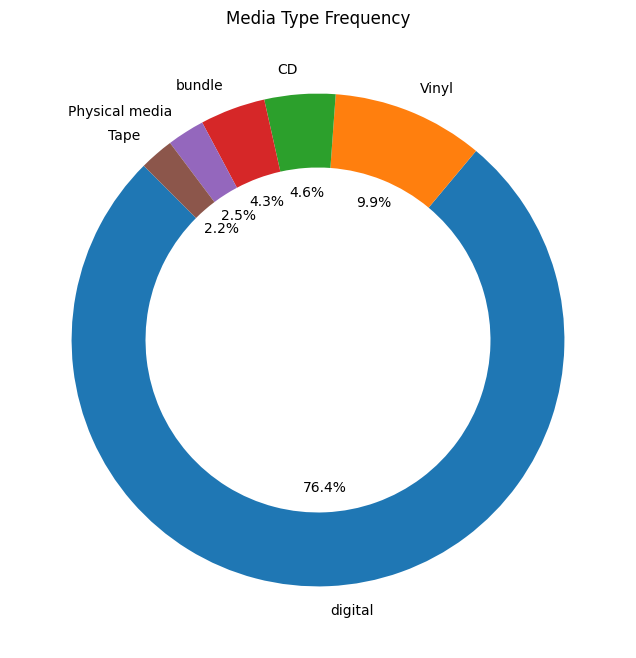

In [170]:
# Calculate the frequency of each media_type
media_type_counts = df["media_type"].value_counts()

# Create a donut chart
plt.figure(figsize=(8, 8))
plt.pie(media_type_counts, labels=media_type_counts.index, autopct='%1.1f%%', startangle=135, wedgeprops={'width': 0.3})
plt.title("Media Type Frequency")
plt.show()

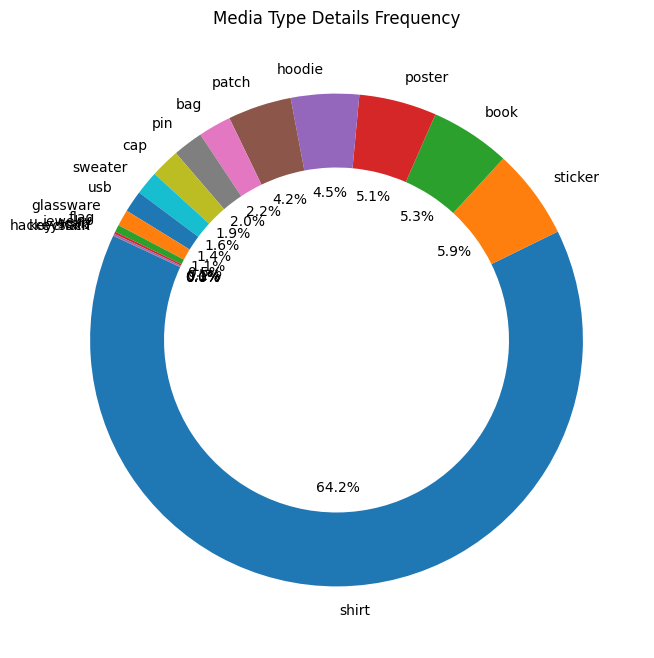

In [166]:
# Calculate the frequency of each media_type
media_type_counts = df[df["merch_type"] != "other"]["merch_type"].value_counts()

# Create a donut chart
plt.figure(figsize=(8, 8))
plt.pie(media_type_counts, labels=media_type_counts.index, autopct='%1.1f%%', startangle=155, wedgeprops={'width': 0.3})
plt.title("Media Type Details Frequency")
plt.show()

#### BACKUP CHECKPOINT

In [71]:
# save backup
df_filename = 'bandcamp-sales-v04-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v04-eda.pkl


In [72]:
# restore backup
df_filename = 'bandcamp-sales-v04-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,country_code,country,amount_paid_fmt,item_price,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle
0,gb,United Kingdom,$9.99,9.99,9.99,NaN,Girl Band,USD,NaN,9.99,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0
1,fi,Finland,£1,1.00,1.00,NaN,Jirah,GBP,NaN,1.30,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0
2,fi,Finland,£3,3.00,3.00,NaN,D-Ther,GBP,NaN,3.90,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0
3,gb,United Kingdom,€10.50,10.50,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,CD,no details,0,other,0
4,us,United States,$1,1.00,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,NaN,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0,other,0


# Treating target related columns

This could be done earlier, but by doing transformations on the reduced data set productivity will be higher.

- `amount_paid_usd` column contains the total cost of purchase in unified format - converted from original currency to USD for compatibility. 
  - This is the target variable for understanding sales trends.
  - This data is derived from columns:
    - `amount_paid_fmt`, `amount_paid`, `item_price`, `currency`, `amount_over_fmt`
    - Data relation formula in pseudocode:
    - ```amount_paid_usd = (item_price + amount_over_fmt = amount_paid) convert from currency to USD```
    - This assumption must be verified before any of the columns will be dropped.

- `amount_over_fmt` column contains information about voluntarily paid over the item price in the seller's currency. It is important for the project objective of exploring fan generosity.
  - this is stored as categorical data, not numeric
  - this data is stored in seller's currency and needs to be unified by converting into dollars. For this `currency` column is necessary. 
  - 88.09% of the column is missing data. That are cases where buyers did not pay extra on top of `item_price`. Must be filled with 0.


## Convert `amount_over_fmt` and `amount_paid_fmt` from categorical to numerical

In [73]:
df["amount_over_fmt"].apply(type).value_counts()

amount_over_fmt
<class 'float'>    880867
<class 'str'>      119133
Name: count, dtype: int64

In [74]:
df[df["amount_over_fmt"].apply(lambda x: isinstance(x, str))]["amount_over_fmt"].head(5)

13      €2
18      $6
27      $5
28     £10
37    $197
Name: amount_over_fmt, dtype: object

In [75]:
# Remove currency symbols from string entries and convert to float
def clean_amount_over(x):
    if isinstance(x, str):
        # Remove any common currency symbol using regex
        cleaned = re.sub(r"[^\d.,]", "", x)
        try:
            return float(cleaned)
        except ValueError:
            return np.nan
    return x  # already float or NaN

df["amount_over_fmt"] = df["amount_over_fmt"].apply(clean_amount_over)

# Ensure NaNs are set where values were missing or invalid
df["amount_over_fmt"] = df["amount_over_fmt"].replace("", np.nan)

In [76]:
# Fill NaNs with 0 where no extra payment was made
df["amount_over_fmt"] = df["amount_over_fmt"].fillna(0.0)

In [77]:
# Veerify that the columns is cleaned now
print("for amount_over_fmt:\n")
print(f"All values sould be float now: {df["amount_over_fmt"].dtype}\n")
print(f"No null values are expected: {df["amount_over_fmt"].isnull().sum()}\n")
print(f"Treated as numeric and sow automatical stats\n: {df["amount_over_fmt"].describe()}\n")
# The stats are useless now because all values are in different currencies

for amount_over_fmt:

All values sould be float now: float64

No null values are expected: 0

Treated as numeric and sow automatical stats
: count    1000000.000000
mean           1.415943
std           17.658453
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max          999.200000
Name: amount_over_fmt, dtype: float64



## Convert currencies
- For perfect precision, currency convertion rate should be used accordign to the timestamp.
- Precision is not so important as unification of data for machine learning. 
- As we have `amount_paid_usd` already and "currency" for reference  we can deduce convertion rate from it.

In [78]:
# Verify that amount_paid_usd ≈ amount_paid when currency is USD
usd_rows = df["currency"] == "USD"
usd_diff = (df.loc[usd_rows, "amount_paid_usd"] - df.loc[usd_rows, "amount_paid"]).abs()

print("USD mismatches:", (usd_diff > 0.01).sum(), "/", usd_rows.sum())

USD mismatches: 0 / 455569


In [79]:
# Calculate conversion rate
df["conversion_rate"] = df["amount_paid_usd"] / df["amount_paid"]

# Fill NaNs or infs (from 0 amounts) with 1.0 only for USD, else leave NaN
df.loc[df["currency"] == "USD", "conversion_rate"] = 1.0

df[["currency", "amount_paid", "amount_paid_usd", "conversion_rate"]].sample(5)

,currency,amount_paid,amount_paid_usd,conversion_rate
628164,USD,8.0,8.00,1.00
939009,USD,8.0,8.00,1.00
675426,EUR,1.0,1.16,1.16
244180,EUR,0.5,0.59,1.18
668444,USD,10.0,10.00,1.00


In [80]:
# Convert fan donations to USD
df["amount_over_usd"] = df["amount_over_fmt"] * df["conversion_rate"]

df["amount_over_usd"].describe()

count    1000000.000000
mean           0.874630
std            6.984831
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max         1276.953795
Name: amount_over_usd, dtype: float64

In [81]:
# Convert item original price to USD
df["item_price_usd"] = df["item_price"] * df["conversion_rate"]

df["item_price_usd"].describe()

count    1000000.000000
mean           7.951427
std           10.511279
min            0.000000
25%            1.288000
50%            5.070000
75%           10.000000
max         1000.000000
Name: item_price_usd, dtype: float64

In [82]:
# double-check tere are no missing values
columns_money = ["amount_paid", "amount_paid_usd", "item_price", "item_price_usd", "amount_over_fmt", "amount_over_usd", "currency", "conversion_rate", "amount_paid_fmt"]
df[columns_money].isnull().sum()

amount_paid        0
amount_paid_usd    0
item_price         0
item_price_usd     0
amount_over_fmt    0
amount_over_usd    0
currency           0
conversion_rate    0
amount_paid_fmt    0
dtype: int64

### BACKUP CHECKPOINT

In [83]:
# save backup
df_filename = 'bandcamp-sales-v05-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v05-eda.pkl


In [84]:
# restore backup
df_filename = 'bandcamp-sales-v05-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,country_code,country,amount_paid_fmt,item_price,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle,conversion_rate,amount_over_usd,item_price_usd
0,gb,United Kingdom,$9.99,9.99,9.99,NaN,Girl Band,USD,NaN,9.99,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.00,0.0,9.99
1,fi,Finland,£1,1.00,1.00,NaN,Jirah,GBP,NaN,1.30,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.30,0.0,1.30
2,fi,Finland,£3,3.00,3.00,NaN,D-Ther,GBP,NaN,3.90,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.30,0.0,3.90
3,gb,United Kingdom,€10.50,10.50,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,CD,no details,0,other,0,1.18,0.0,12.39
4,us,United States,$1,1.00,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0,other,0,1.00,0.0,1.00


## Verify that amount_paid = item_price + amount_over_fmt

In [85]:
# Compute raw difference (can be negative or positive)
df["paid_usd_delta"] = df["amount_paid_usd"] - (df["item_price_usd"] + df["amount_over_usd"])

# Split into overpayment and underpayment
df["overpayment_usd"] = df["paid_usd_delta"].apply(lambda x: x if x > 0 else 0)
df["underpayment_usd"] = df["paid_usd_delta"].apply(lambda x: -x if x < 0 else 0)

columns_money.append("paid_usd_delta")
columns_money.append("overpayment_usd")
columns_money.append("underpayment_usd")

# Show the total count of rows for each category
print("Overpayment:", df["overpayment_usd"].gt(0).sum())
print("Underpayment:", df["underpayment_usd"].gt(0).sum())

Overpayment: 239357
Underpayment: 70099


Business context assumptions:
- Underpayment might be due to discounts
- Overpayment might be due to fees
- Overpayment might be explained by technical errors collecting volunteerly payment in `amount_over_fmt` when collecitng data or on the Bandcamp back-end side.

### Decompose overpayment and underpayment cases

#### Case reference for payments

#### 1. Overpayment: `amount_paid > item_price + amount_over_fmt`

| Case  | Conditions                                         | Description                                                                  | Count  |
|-------|----------------------------------------------------|------------------------------------------------------------------------------|--------|
| 11    | `item_price_usd > 0` and `amount_over_usd == 0`    | Item was not free. No extra donation made.                                   | 86,690 |
| 12    | `item_price_usd == 0` and `amount_over_usd == 0`   | Item was free. No donation made.                                             | 73,709 |
| 13    | `item_price_usd == 0` and `amount_over_usd > 0`    | Item was free. Customer added donation.                                      | 1,035  |

#### 2. Underpayment: `amount_paid < item_price + amount_over_fmt`

| Case  | Conditions                                                                 | Description                                                                                             | Count  | Notes                             |
|-------|----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|--------|-----------------------------------|
| 21    | `item_price_usd == 0` and `amount_paid_usd == 0`                           | Item was free. Customer paid nothing — legit free access.                                               | 0      | Not counted as underpayment       |
| 22    | `item_price_usd > 0` and `amount_paid_usd < item_price_usd` and `amount_over_usd == 0` | Item had a price. Customer underpaid with no donation.                                                 | 12,295 | Discount applied?                 |
| 23    | `item_price_usd == 0` and `amount_over_usd > 0` and `amount_paid_usd < amount_over_usd` | Free item. Customer donated less than suggested amount.                                                 | 1,683  | Voluntary donation, no minimum   |
| 24    | `item_price_usd > 0` and `amount_over_usd > 0` and `amount_paid_usd < item_price_usd + amount_over_usd` | Item had price + donation. Customer paid less than full total.                          | 7,527  | Discount applied?                 |

In [86]:
# OVERPAYMENT CASES
overpaid_df = df[df["overpayment_usd"] > 0]

# Case 11: Paid full price, no donation
over_case_11 = overpaid_df[
    (overpaid_df["item_price_usd"] > 0) &
    (overpaid_df["amount_over_usd"] == 0)
]

# Case 12: Free item, no donation
over_case_12 = overpaid_df[
    (overpaid_df["item_price_usd"] == 0) &
    (overpaid_df["amount_over_usd"] == 0)
]

# Case 13: Free item, customer donated
over_case_13 = overpaid_df[
    (overpaid_df["item_price_usd"] == 0) &
    (overpaid_df["amount_over_usd"] > 0)
]


# UNDERPAYMENT CASES
underpaid_df = df[df["underpayment_usd"] > 0]

# Case 21: Legit free item, should have paid nothing
under_case_21 = underpaid_df[
    (underpaid_df["item_price_usd"] == 0) &
    (underpaid_df["amount_paid_usd"] == 0)
]

# Case 22: Paid less than price, no donation
under_case_22 = underpaid_df[
    (underpaid_df["item_price_usd"] > 0) &
    (underpaid_df["amount_paid_usd"] < underpaid_df["item_price_usd"]) &
    (underpaid_df["amount_over_usd"] == 0)
]

# Case 23: Underpaid suggested donation
under_case_23 = underpaid_df[
    (underpaid_df["item_price_usd"] == 0) &
    (underpaid_df["amount_over_usd"] > 0) &
    (underpaid_df["amount_paid_usd"] < underpaid_df["amount_over_usd"])
]

# Case 24: Paid something, but not full expected total
under_case_24 = underpaid_df[
    (underpaid_df["item_price_usd"] > 0) &
    (underpaid_df["amount_over_usd"] > 0) &
    (underpaid_df["amount_paid_usd"] < (underpaid_df["item_price_usd"] + underpaid_df["amount_over_usd"]))
]


# Print counts
print("Overpayment cases:")
print("Case 11:", len(over_case_11))
print("Case 12:", len(over_case_12))
print("Case 13:", len(over_case_13))

print("\nUnderpayment cases:")
print("Case 21:", len(under_case_21))
print("Case 22:", len(under_case_22))
print("Case 23:", len(under_case_23))
print("Case 24:", len(under_case_24))

Overpayment cases:
Case 11: 154089
Case 12: 73709
Case 13: 1035

Underpayment cases:
Case 21: 0
Case 22: 60889
Case 23: 1683
Case 24: 7527


Interpreting the results:
- Overpayment is much more common than underpayment overall.
- Case 11 is dominant — buyers often just pay the listed price, and still show a “fee” (platform-level overcharge).
- Case 13 is the strongest “generosity” signal — buyers who donate money for a free item.


Look closer to overpayment cases for top values:

In [87]:
underpaid_df[columns_money].sort_values(by="paid_usd_delta", ascending=False).head()

,amount_paid,amount_paid_usd,item_price,item_price_usd,amount_over_fmt,amount_over_usd,currency,conversion_rate,amount_paid_fmt,paid_usd_delta,overpayment_usd,underpayment_usd
839226,11.00,0.49,11.00,0.49,0.0,0.0,MXN,0.044545,$11 MXN,-5.551115e-17,0.0,5.551115e-17
327237,9.00,0.43,9.00,0.43,0.0,0.0,MXN,0.047778,$9 MXN,-5.551115e-17,0.0,5.551115e-17
839227,11.00,0.49,11.00,0.49,0.0,0.0,MXN,0.044545,$11 MXN,-5.551115e-17,0.0,5.551115e-17
95975,0.75,0.89,0.75,0.89,0.0,0.0,EUR,1.186667,€0.75,-1.110223e-16,0.0,1.110223e-16
63789,0.75,0.89,0.75,0.89,0.0,0.0,EUR,1.186667,€0.75,-1.110223e-16,0.0,1.110223e-16


In [88]:
overpaid_df[columns_money].sort_values(by="paid_usd_delta", ascending=False).head()

,amount_paid,amount_paid_usd,item_price,item_price_usd,amount_over_fmt,amount_over_usd,currency,conversion_rate,amount_paid_fmt,paid_usd_delta,overpayment_usd,underpayment_usd
378715,1000.0,1000.00,0.0,0.0000,0.0,0.0,USD,1.000000,"$1,000",1000.0000,1000.0000,0.0
782909,1000.0,1000.00,0.0,0.0000,0.0,0.0,USD,1.000000,"$1,000",1000.0000,1000.0000,0.0
854025,50000.0,474.29,0.0,0.0000,0.0,0.0,JPY,0.009486,"¥50,000",474.2900,474.2900,0.0
159434,10000.0,94.20,0.0,0.0000,0.0,0.0,JPY,0.009420,"¥10,000",94.2000,94.2000,0.0
216525,10000.0,94.58,100.0,0.9458,0.0,0.0,JPY,0.009458,"¥10,000",93.6342,93.6342,0.0


Look closer to underpayment cases:

In [89]:
under_case_22[columns_money].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
amount_paid,60889.0,16.34,110.80,0.20,1.50,3.00,10.00,6120.00
amount_paid_usd,60889.0,8.30,11.68,0.20,1.78,3.84,11.61,536.54
item_price,60889.0,18.58,147.22,0.20,1.50,3.99,10.00,9180.00
item_price_usd,60889.0,8.94,12.83,0.20,1.78,4.00,11.72,536.54
amount_over_fmt,60889.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
amount_over_usd,60889.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
conversion_rate,60889.0,1.13,0.19,0.00,1.00,1.18,1.19,1.31
paid_usd_delta,60889.0,-0.63,4.39,-384.75,-0.00,-0.00,-0.00,-0.00
overpayment_usd,60889.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
underpayment_usd,60889.0,0.63,4.39,0.00,0.00,0.00,0.00,384.75


In [90]:
under_case_23[columns_money].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
amount_paid,1683.0,16.78,74.33,1.10,3.00,5.00,6.22,831.00
amount_paid_usd,1683.0,6.70,6.28,1.40,3.56,5.86,6.47,117.76
item_price,1683.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_price_usd,1683.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
amount_over_fmt,1683.0,16.78,74.33,1.10,3.00,5.00,6.22,831.00
amount_over_usd,1683.0,6.70,6.28,1.40,3.56,5.86,6.47,117.76
conversion_rate,1683.0,1.14,0.25,0.01,1.17,1.19,1.28,1.30
paid_usd_delta,1683.0,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
overpayment_usd,1683.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
underpayment_usd,1683.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [91]:
under_case_23["underpayment_usd"].sum()

np.float64(1.5576429035490946e-12)

In [92]:
under_case_24[columns_money].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
amount_paid,7527.0,27.35,142.69,1.70,6.66,10.00,22.22,5777.00
amount_paid_usd,7527.0,18.76,33.27,1.99,7.05,12.86,23.70,1279.50
item_price,7527.0,16.86,108.69,0.25,2.99,7.00,15.00,5000.00
item_price_usd,7527.0,11.05,13.62,0.29,2.99,7.65,15.29,389.06
amount_over_fmt,7527.0,10.48,48.33,1.01,2.01,4.00,6.15,999.20
amount_over_usd,7527.0,7.71,30.46,1.12,2.37,3.88,6.47,1276.95
conversion_rate,7527.0,1.09,0.22,0.00,1.00,1.17,1.27,1.30
paid_usd_delta,7527.0,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
overpayment_usd,7527.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
underpayment_usd,7527.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In case 22 the underpayment max is severe. 

In [93]:
# Top 10 underpayment cases for under_case_22
print("Top 10 underpayment cases for under_case_22:")
under_case_22[columns_money + columns_media].sort_values(by="underpayment_usd", ascending=False).head(10)


Top 10 underpayment cases for under_case_22:


,amount_paid,amount_paid_usd,item_price,item_price_usd,amount_over_fmt,amount_over_usd,currency,conversion_rate,amount_paid_fmt,paid_usd_delta,overpayment_usd,underpayment_usd,media_type,media_type_details,discography_size,merch_type,is_bundle
574556,20.25,20.25,405.000000,405.000000,0.0,0.0,USD,1.000000,$20.25,-384.750000,0.0,384.750000,digital,full digital discography,107,other,0
219928,12.00,14.26,225.759995,268.278127,0.0,0.0,EUR,1.188333,€12,-254.018127,0.0,254.018127,digital,full digital discography,142,other,0
285623,2.00,2.00,231.990005,231.990005,0.0,0.0,USD,1.000000,$2,-229.990005,0.0,229.990005,digital,album,0,other,0
624848,33.68,39.29,202.080002,235.740002,0.0,0.0,EUR,1.166568,€33.68,-196.450002,0.0,196.450002,digital,full digital discography,57,other,0
272447,175.00,175.00,350.000000,350.000000,0.0,0.0,USD,1.000000,$175,-175.000000,0.0,175.000000,bundle,no details,0,other,1
539766,20.00,23.42,163.500000,191.458500,0.0,0.0,EUR,1.171000,€20,-168.038500,0.0,168.038500,digital,full digital discography,57,other,0
615832,21.00,21.00,138.300003,138.300003,0.0,0.0,USD,1.000000,$21,-117.300003,0.0,117.300003,digital,full digital discography,61,other,0
744657,5.00,5.00,100.000000,100.000000,0.0,0.0,USD,1.000000,$5,-95.000000,0.0,95.000000,digital,album,0,other,0
300555,25.00,32.36,90.400002,117.013762,0.0,0.0,GBP,1.294400,£25,-84.653762,0.0,84.653762,digital,full digital discography,48,other,0
577979,7.00,7.00,91.000000,91.000000,0.0,0.0,USD,1.000000,$1,-84.000000,0.0,84.000000,digital,single,0,other,0


#### BACKUP CHECKPOINT

In [94]:
# save backup
df_filename = 'bandcamp-sales-v06-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v06-eda.pkl


In [95]:
# restore backup
df_filename = 'bandcamp-sales-v06-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,country_code,country,amount_paid_fmt,item_price,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle,conversion_rate,amount_over_usd,item_price_usd,paid_usd_delta,overpayment_usd,underpayment_usd
0,gb,United Kingdom,$9.99,9.99,9.99,NaN,Girl Band,USD,NaN,9.99,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.00,0.0,9.99,2.288818e-07,2.288818e-07,0.000000e+00
1,fi,Finland,£1,1.00,1.00,NaN,Jirah,GBP,NaN,1.30,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.30,0.0,1.30,0.000000e+00,0.000000e+00,0.000000e+00
2,fi,Finland,£3,3.00,3.00,NaN,D-Ther,GBP,NaN,3.90,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.30,0.0,3.90,-4.440892e-16,0.000000e+00,4.440892e-16
3,gb,United Kingdom,€10.50,10.50,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,CD,no details,0,other,0,1.18,0.0,12.39,-1.776357e-15,0.000000e+00,1.776357e-15
4,us,United States,$1,1.00,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0,other,0,1.00,0.0,1.00,0.000000e+00,0.000000e+00,0.000000e+00


Lookup rows where overpayment > 10% of item_price_usd

In [96]:
# Subset of overpayments that are more than 10% of the item price
overpaind_10p_df = overpaid_df[overpaid_df["overpayment_usd"] > 0.1 * overpaid_df["item_price_usd"]].sort_values(by="paid_usd_delta", ascending=False)
print(f"Total records: {len(overpaind_10p_df)}")
overpaind_10p_df[columns_money].head()

Total records: 116397


,amount_paid,amount_paid_usd,item_price,item_price_usd,amount_over_fmt,amount_over_usd,currency,conversion_rate,amount_paid_fmt,paid_usd_delta,overpayment_usd,underpayment_usd
782909,1000.0,1000.00,0.0,0.0000,0.0,0.0,USD,1.000000,"$1,000",1000.0000,1000.0000,0.0
378715,1000.0,1000.00,0.0,0.0000,0.0,0.0,USD,1.000000,"$1,000",1000.0000,1000.0000,0.0
854025,50000.0,474.29,0.0,0.0000,0.0,0.0,JPY,0.009486,"¥50,000",474.2900,474.2900,0.0
159434,10000.0,94.20,0.0,0.0000,0.0,0.0,JPY,0.009420,"¥10,000",94.2000,94.2000,0.0
216525,10000.0,94.58,100.0,0.9458,0.0,0.0,JPY,0.009458,"¥10,000",93.6342,93.6342,0.0


In [97]:
# Save overpaind_10p_df to a CSV file
overpaind_10p_df.to_csv('../data/suspicious_transactions.csv', index=False)

In [98]:
overpaind_10p_df.columns

Index(['country_code', 'country', 'amount_paid_fmt', 'item_price',
       'amount_paid', 'releases', 'artist_name', 'currency', 'album_title',
       'amount_paid_usd', 'amount_over_fmt', 'hour', 'dayofweek', 'month',
       'year', 'weekday', 'weekend', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'media_type',
       'media_type_details', 'discography_size', 'merch_type', 'is_bundle',
       'conversion_rate', 'amount_over_usd', 'item_price_usd',
       'paid_usd_delta', 'overpayment_usd', 'underpayment_usd'],
      dtype='object')

#### Overpayment by country

In [99]:
columns_investigation = ["country", "overpayment_usd", "item_price_usd", "amount_over_usd", "amount_paid_usd"]

In [100]:
overpaind_10p_df[columns_investigation].head(15)

,country,overpayment_usd,item_price_usd,amount_over_usd,amount_paid_usd
782909,United States,1000.000000,0.000000,0.0,1000.00
378715,United States,1000.000000,0.000000,0.0,1000.00
854025,Australia,474.290000,0.000000,0.0,474.29
159434,Japan,94.200000,0.000000,0.0,94.20
216525,Belgium,93.634200,0.945800,0.0,94.58
216462,Belgium,93.634200,0.945800,0.0,94.58
600543,Japan,92.488500,2.371500,0.0,94.86
144578,Japan,91.845000,2.355000,0.0,94.20
145872,Japan,86.664000,7.536000,0.0,94.20
516285,United States,85.734000,9.526000,0.0,95.26


In [101]:
round(overpaid_df.groupby("country")["overpayment_usd"].sum().sort_values(ascending=False), 2)

country
United States     67442.50
United Kingdom    16603.74
Germany           11335.13
Japan              7592.68
Australia          6749.03
                    ...   
Nigeria               0.02
Rwanda                0.01
Paraguay              0.01
Faroe Islands         0.00
Aruba                 0.00
Name: overpayment_usd, Length: 155, dtype: float64

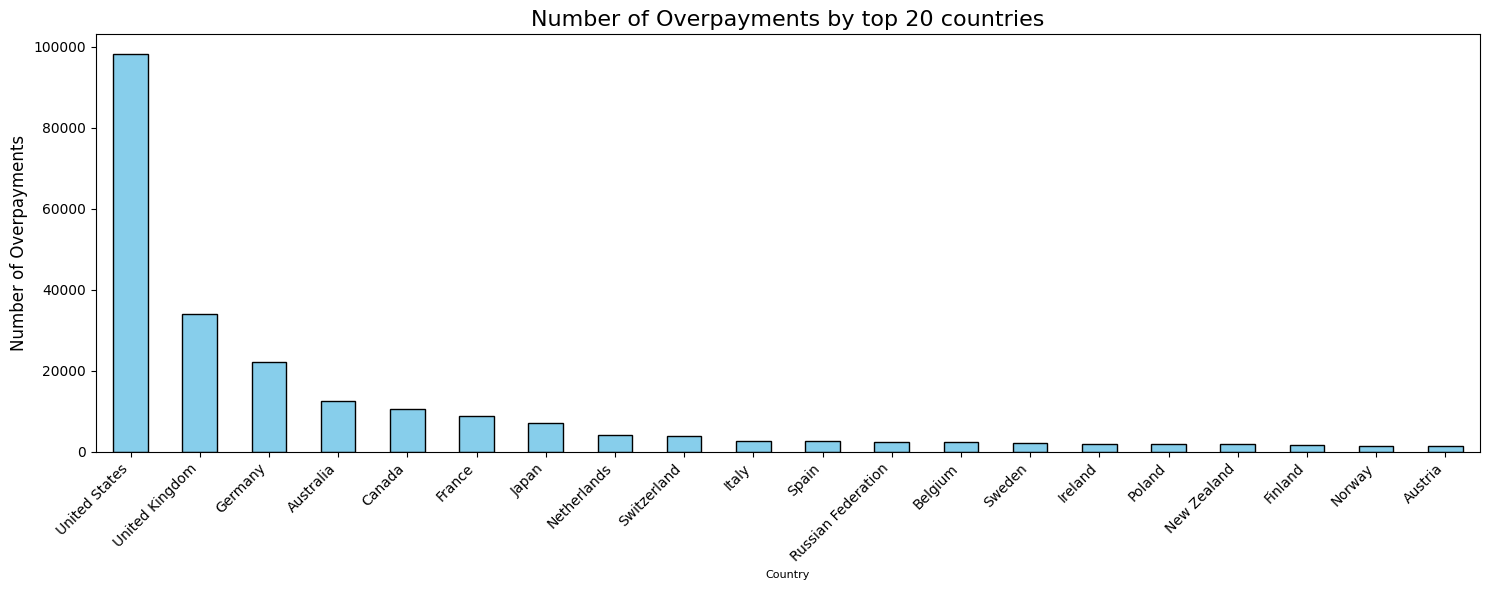

In [102]:
# Count the number of entries for each country in the `overpaid_df`
country_counts = overpaid_df['country'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Number of Overpayments by top 20 countries', fontsize=16)
plt.xlabel('Country', fontsize=8)
plt.ylabel('Number of Overpayments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

In [103]:
subset_high_population = overpaid_df[overpaid_df["country"].isin(["China", "India", "Brazil", "Mexico"])]

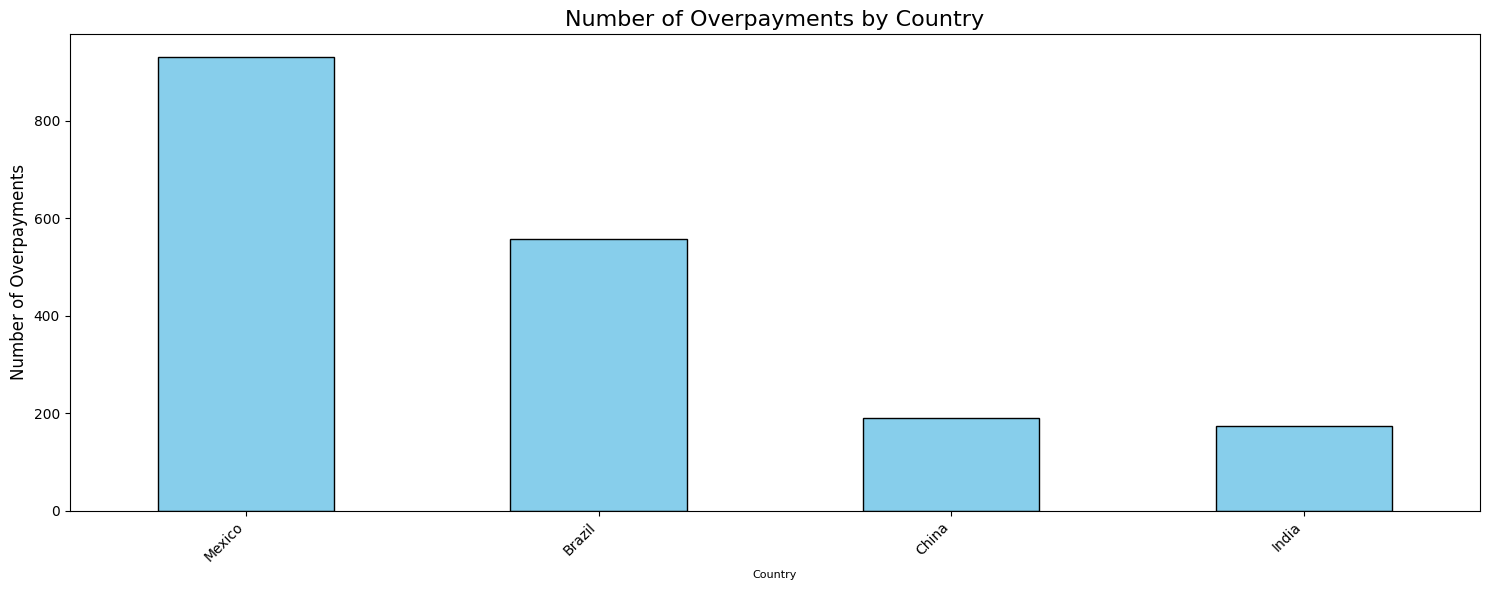

In [104]:
# Count the number of entries for each country in the `overpaid_df`
country_counts = subset_high_population['country'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Number of Overpayments by Country', fontsize=16)
plt.xlabel('Country', fontsize=8)
plt.ylabel('Number of Overpayments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

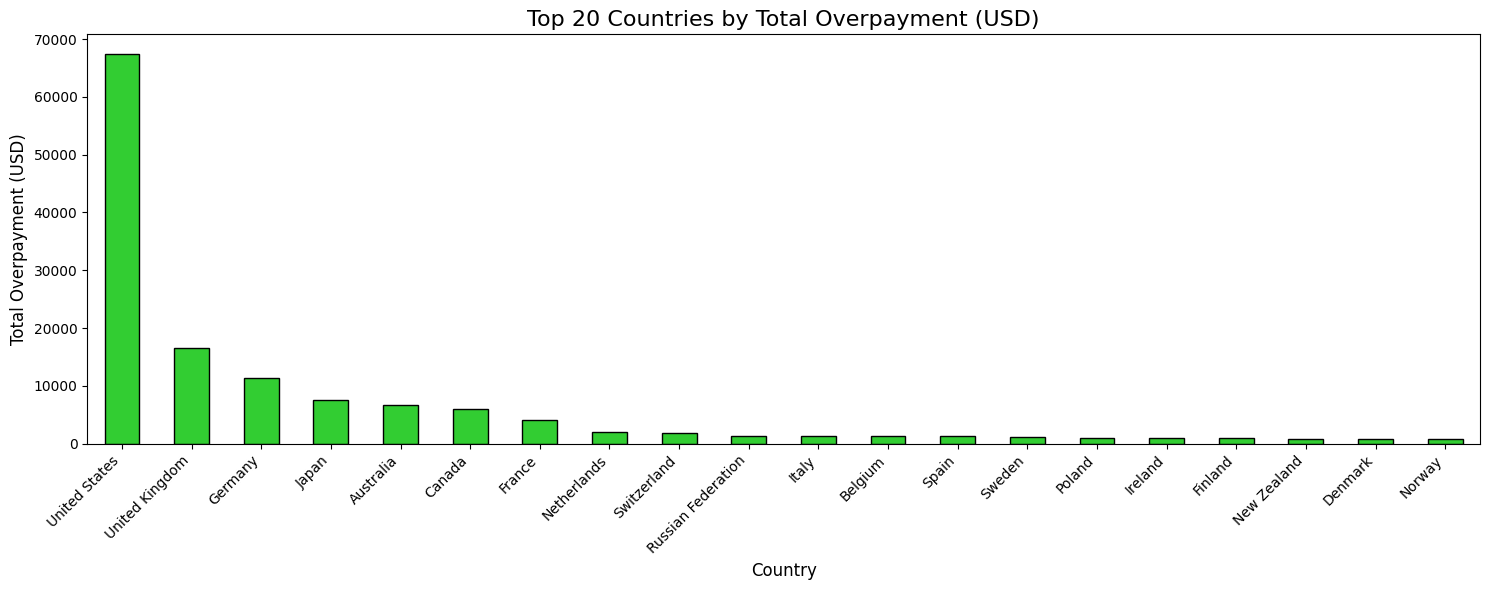

In [105]:
# Group by country and sum the overpayment_usd
overpayment_by_country = overpaid_df.groupby("country")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_country.plot(kind='bar', color='limegreen', edgecolor='black')

# Add labels and title
plt.title('Top 20 Countries by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

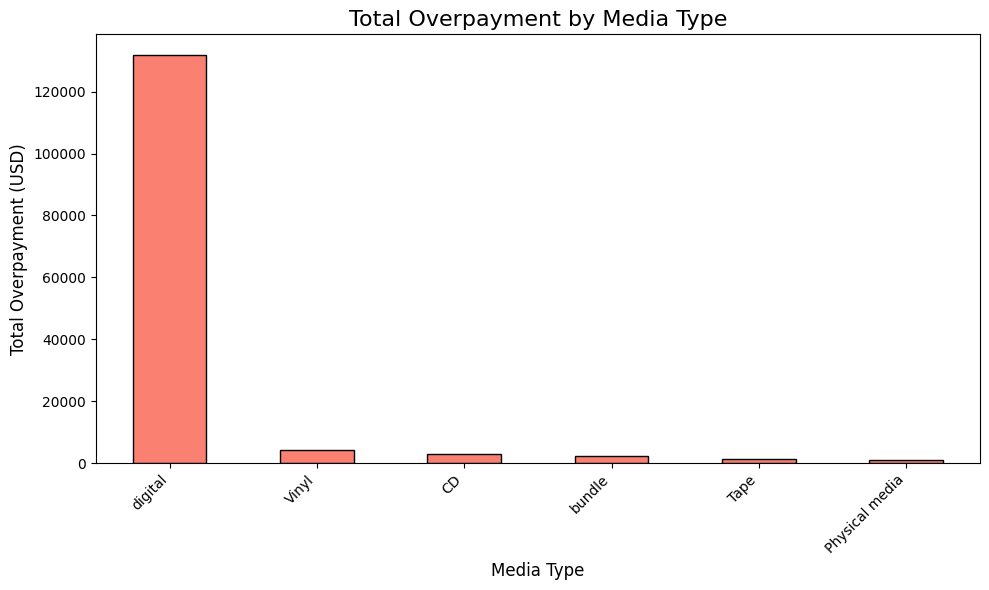

In [106]:
# Group by media type and sum the overpayment
overpayment_by_media_type = overpaid_df.groupby("media_type")["overpayment_usd"].sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
overpayment_by_media_type.plot(kind='bar', color='salmon', edgecolor='black')

# Add labels and title
plt.title('Total Overpayment by Media Type', fontsize=16)
plt.xlabel('Media Type', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

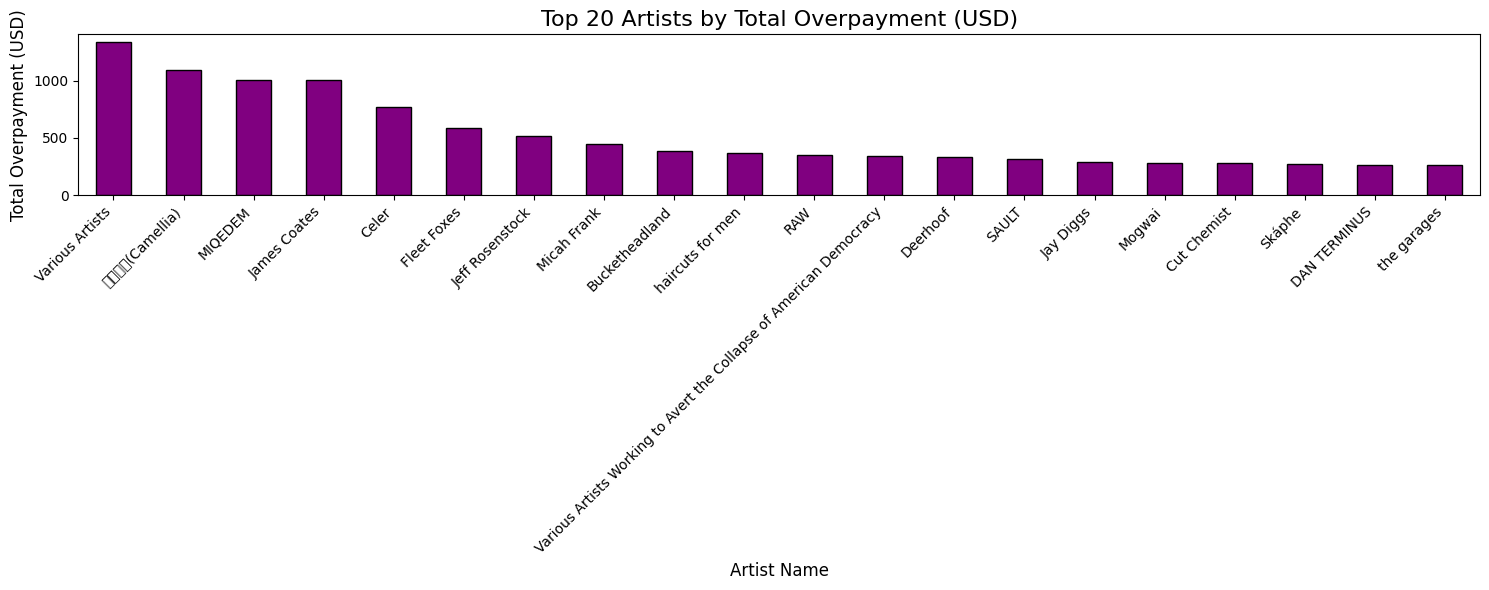

In [107]:
# Group by artist_name and sum the overpayment_usd
overpayment_by_artist = overpaid_df.groupby("artist_name")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_artist.plot(kind='bar', color='purple', edgecolor='black')

# Add labels and title
plt.title('Top 20 Artists by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Artist Name', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

Various Artists Working to Avert the Collapse of American Democracy:
- https://www.discogs.com/release/16288965-Various-Good-Music-To-Avert-The-Collapse-Of-American-Democracy-Volume-2

#### For case 12 - free item, no donation

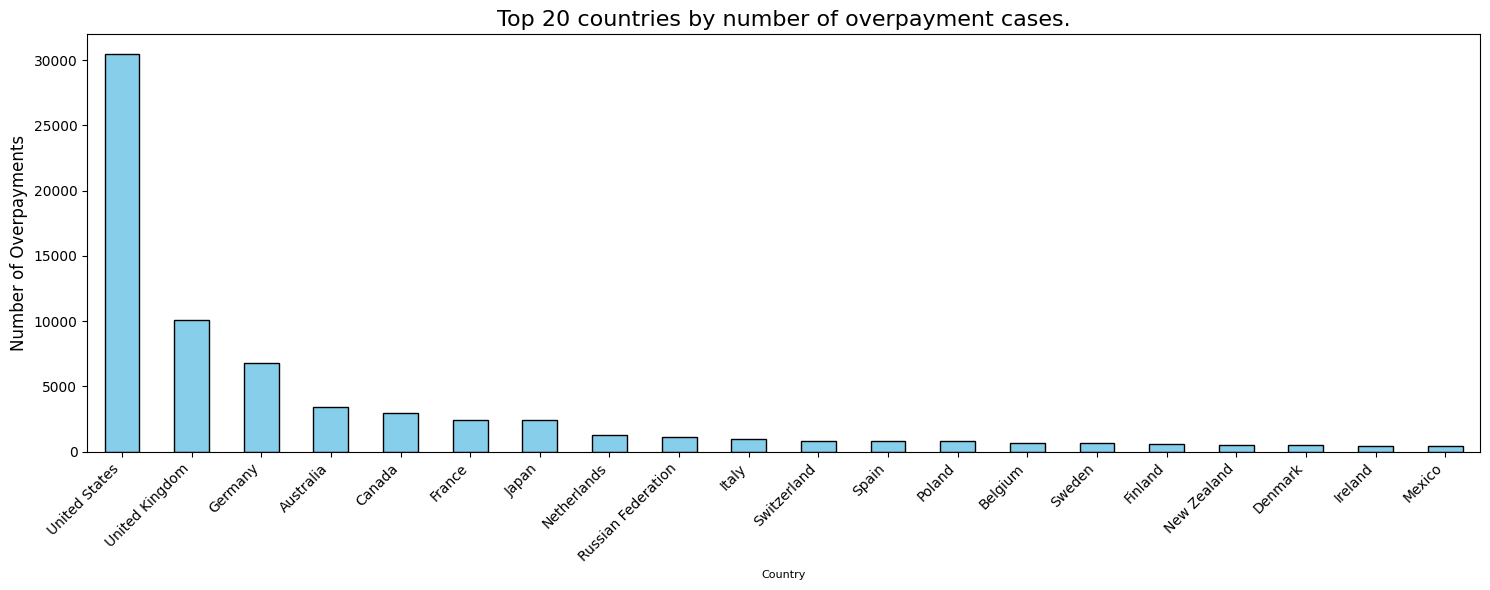

In [108]:
# Count the number of entries for each country in the `overpaid_df`
country_counts = over_case_12['country'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Top 20 countries by number of overpayment cases.', fontsize=16)
plt.xlabel('Country', fontsize=8)
plt.ylabel('Number of Overpayments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

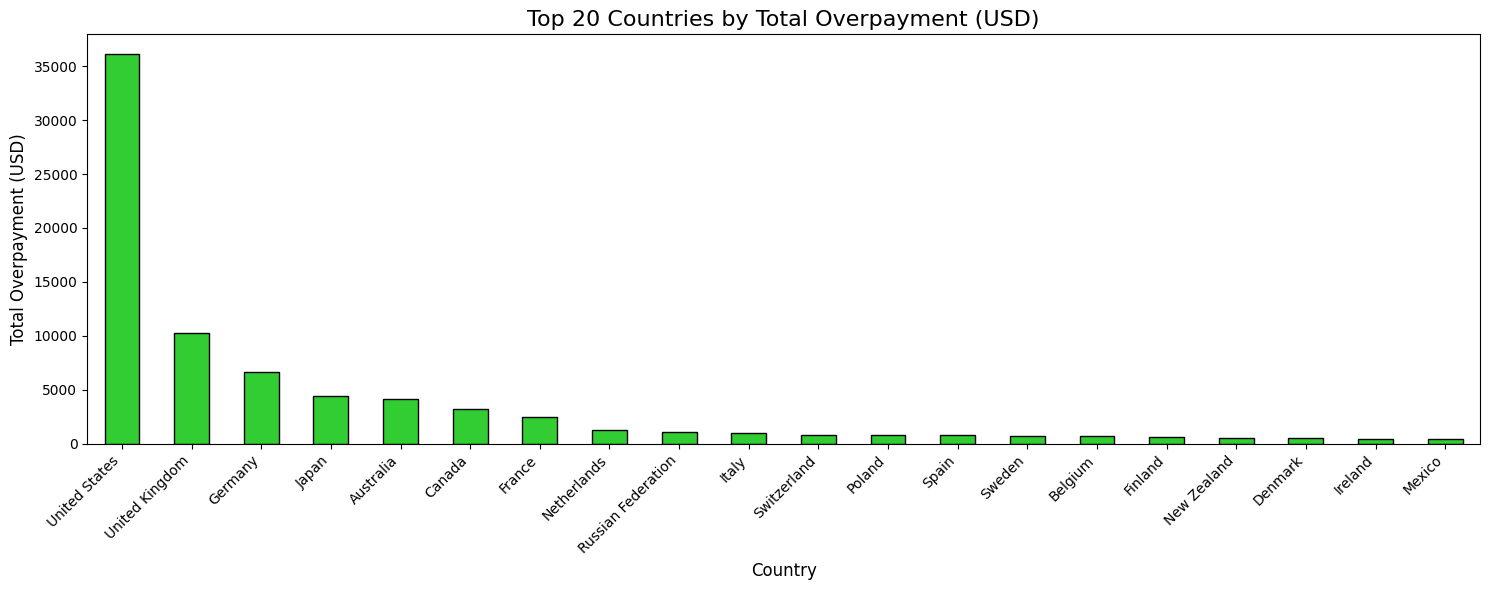

In [109]:
# Group by country and sum the overpayment_usd
overpayment_by_country = over_case_12.groupby("country")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_country.plot(kind='bar', color='limegreen', edgecolor='black')

# Add labels and title
plt.title('Top 20 Countries by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

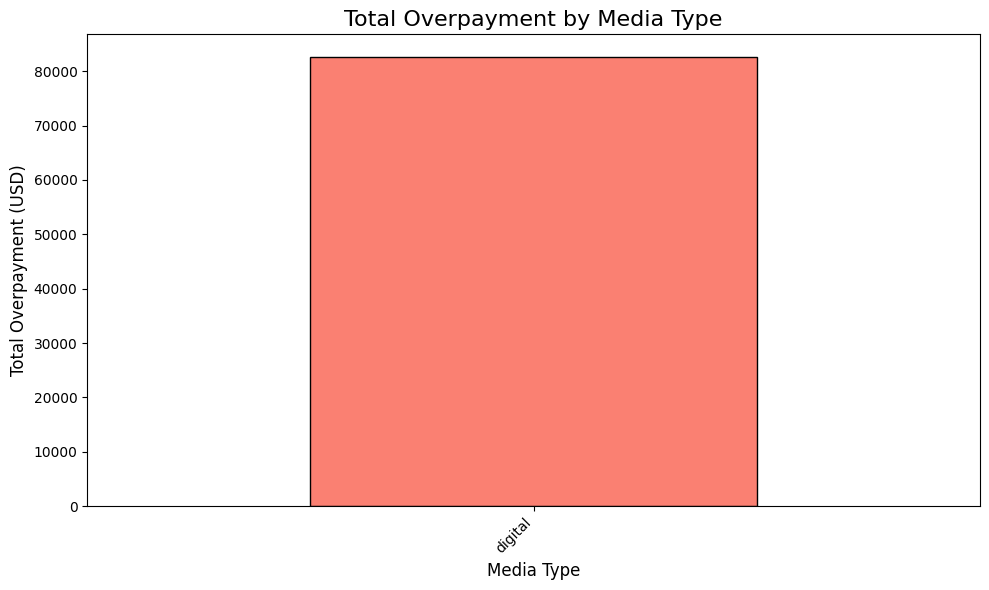

In [110]:
# Group by media type and sum the overpayment
overpayment_by_media_type = over_case_12.groupby("media_type")["overpayment_usd"].sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
overpayment_by_media_type.plot(kind='bar', color='salmon', edgecolor='black')

# Add labels and title
plt.title('Total Overpayment by Media Type', fontsize=16)
plt.xlabel('Media Type', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

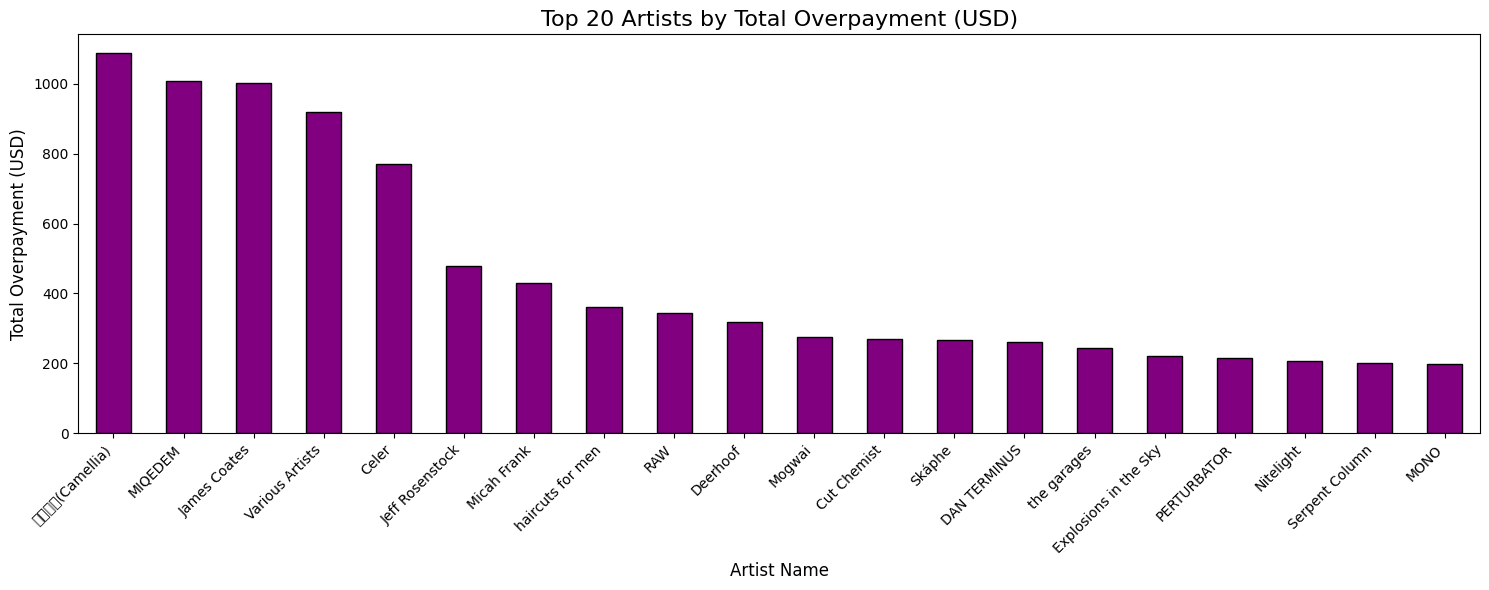

In [111]:
# Group by artist_name and sum the overpayment_usd
overpayment_by_artist = over_case_12.groupby("artist_name")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_artist.plot(kind='bar', color='purple', edgecolor='black')

# Add labels and title
plt.title('Top 20 Artists by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Artist Name', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

#### Case 11 - not free item

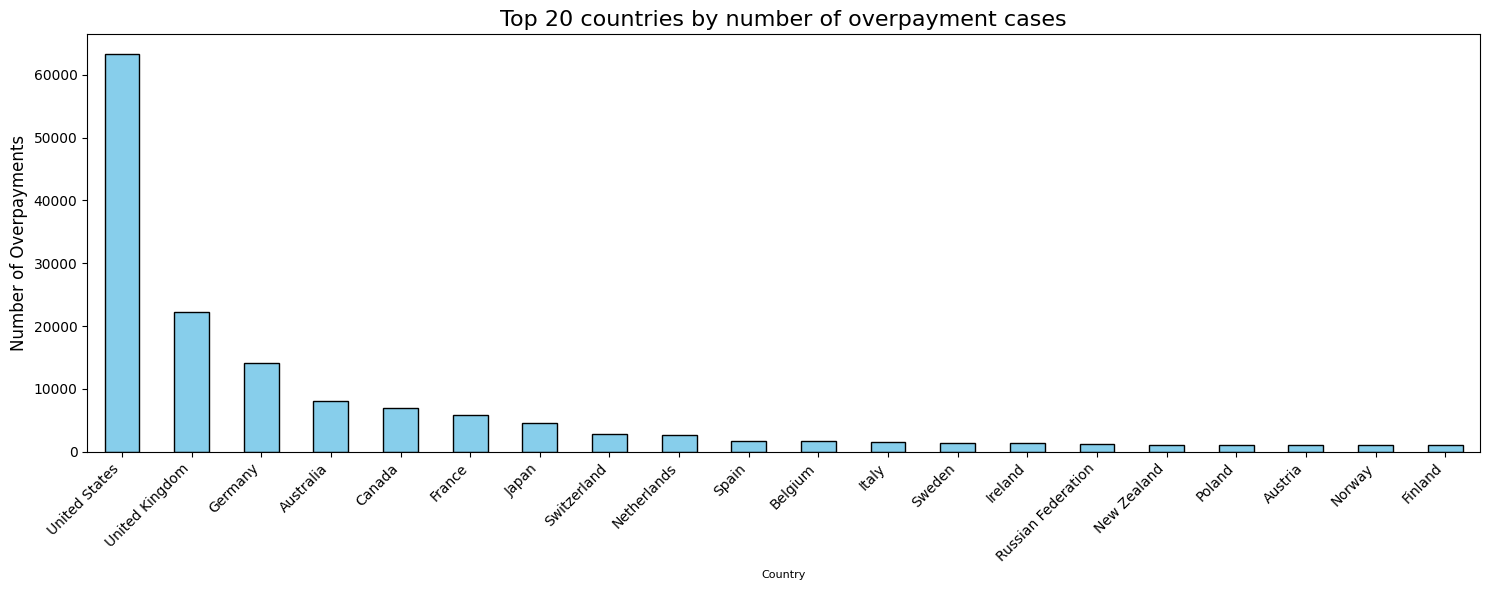

In [112]:
# Count the number of entries for each country in the `overpaid_df`
country_counts = over_case_11['country'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Top 20 countries by number of overpayment cases', fontsize=16)
plt.xlabel('Country', fontsize=8)
plt.ylabel('Number of Overpayments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

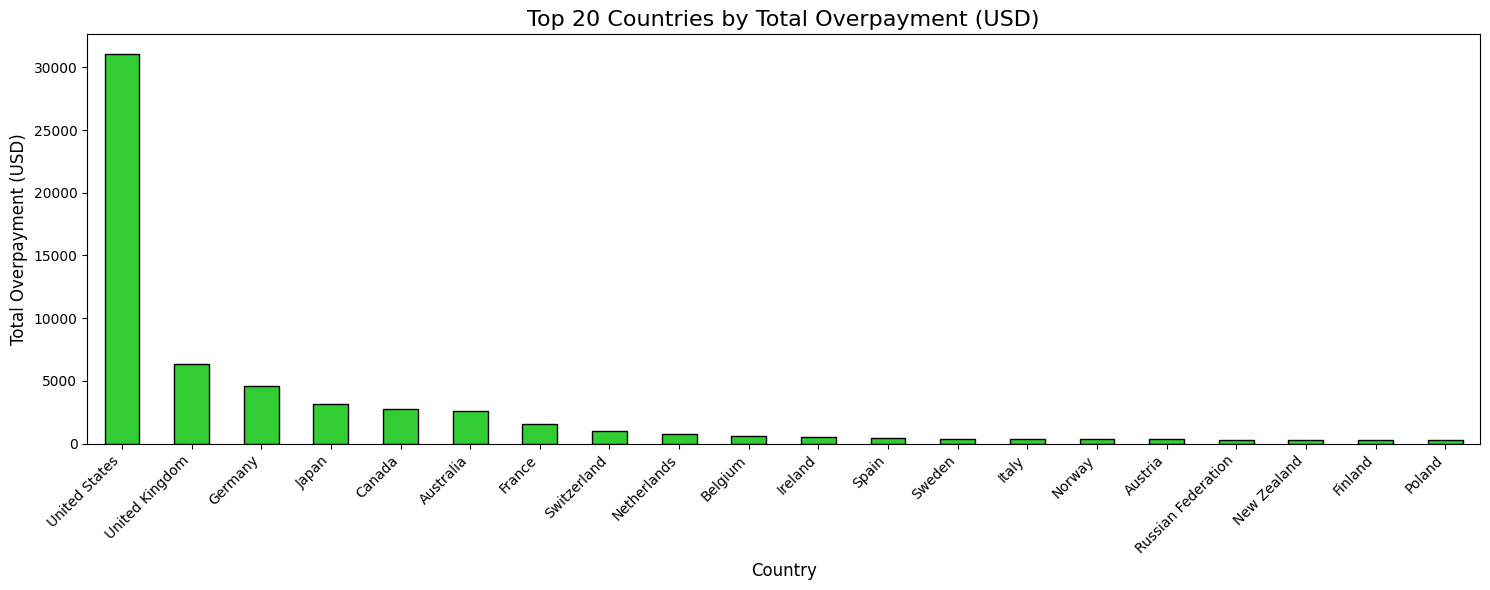

In [113]:
# Group by country and sum the overpayment_usd
overpayment_by_country = over_case_11.groupby("country")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_country.plot(kind='bar', color='limegreen', edgecolor='black')

# Add labels and title
plt.title('Top 20 Countries by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

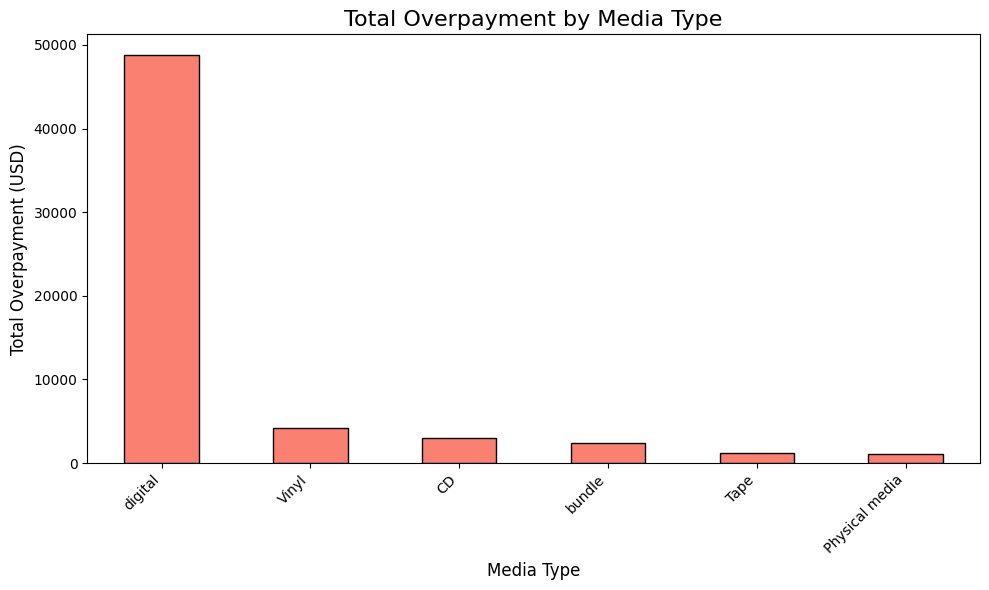

In [114]:
# Group by media type and sum the overpayment
overpayment_by_media_type = over_case_11.groupby("media_type")["overpayment_usd"].sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
overpayment_by_media_type.plot(kind='bar', color='salmon', edgecolor='black')

# Add labels and title
plt.title('Total Overpayment by Media Type', fontsize=16)
plt.xlabel('Media Type', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

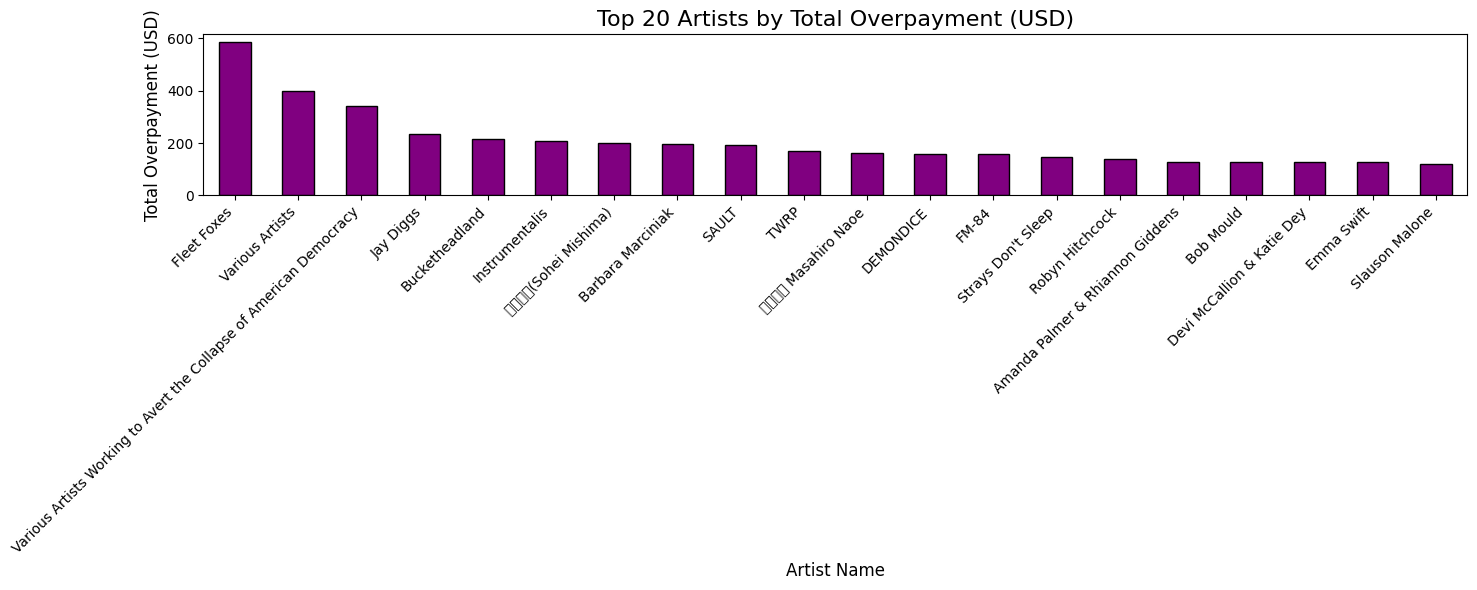

In [115]:
# Group by artist_name and sum the overpayment_usd
overpayment_by_artist = over_case_11.groupby("artist_name")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_artist.plot(kind='bar', color='purple', edgecolor='black')

# Add labels and title
plt.title('Top 20 Artists by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Artist Name', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

#### Case 13 - positive donation

In [116]:
over_case_13.head(5)

,country_code,country,amount_paid_fmt,item_price,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle,conversion_rate,amount_over_usd,item_price_usd,paid_usd_delta,overpayment_usd,underpayment_usd
28,gb,United Kingdom,£10,0.0,10.0,NaN,Mogwai,GBP,NaN,12.99,10.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.299,12.99,0.0,1.776357e-15,1.776357e-15,0.0
407,gb,United Kingdom,£20,0.0,20.0,NaN,Mogwai,GBP,NaN,25.98,20.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.299,25.98,0.0,3.552714e-15,3.552714e-15,0.0
417,fr,France,€11,0.0,11.0,NaN,La P'tite Fumée,EUR,NaN,12.98,11.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.180,12.98,0.0,1.776357e-15,1.776357e-15,0.0
633,gb,United Kingdom,£10,0.0,10.0,NaN,Mogwai,GBP,NaN,12.99,10.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.299,12.99,0.0,1.776357e-15,1.776357e-15,0.0
1098,ca,Canada,£10,0.0,10.0,NaN,Samson Jatto,GBP,NaN,12.99,10.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.299,12.99,0.0,1.776357e-15,1.776357e-15,0.0


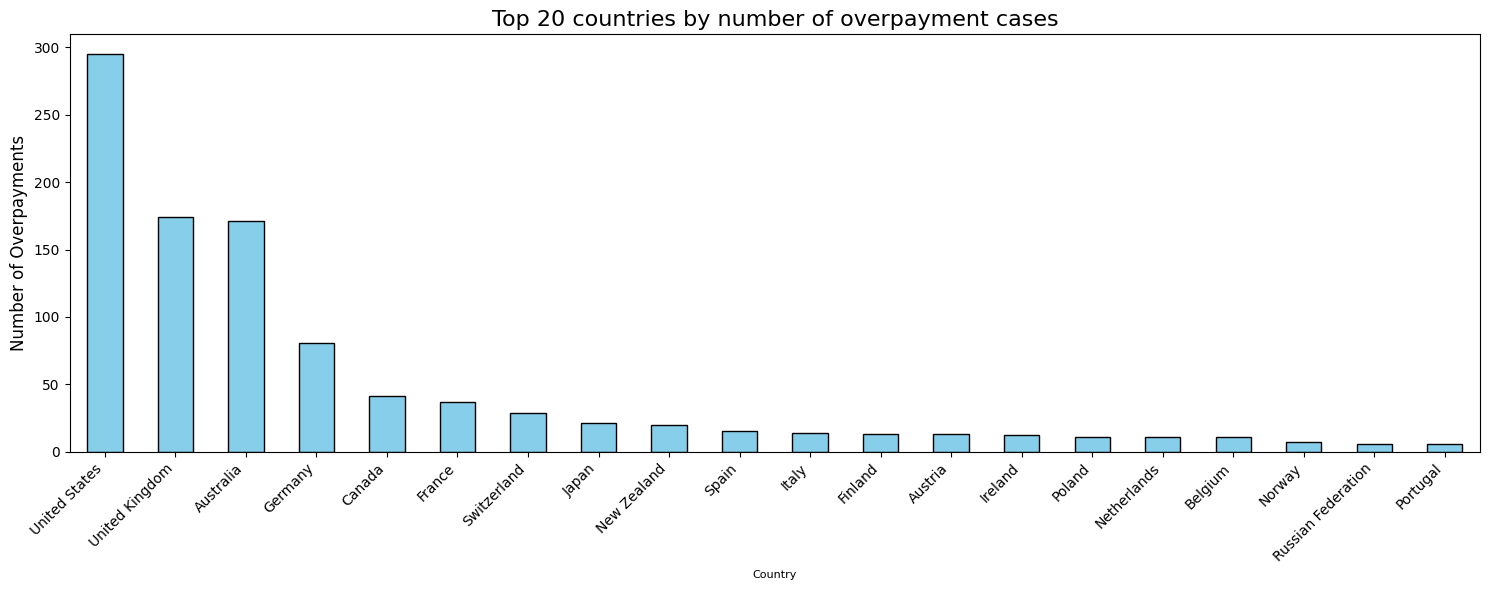

In [117]:
# Count the number of entries for each country in the `overpaid_df`
country_counts = over_case_13['country'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Top 20 countries by number of overpayment cases', fontsize=16)
plt.xlabel('Country', fontsize=8)
plt.ylabel('Number of Overpayments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

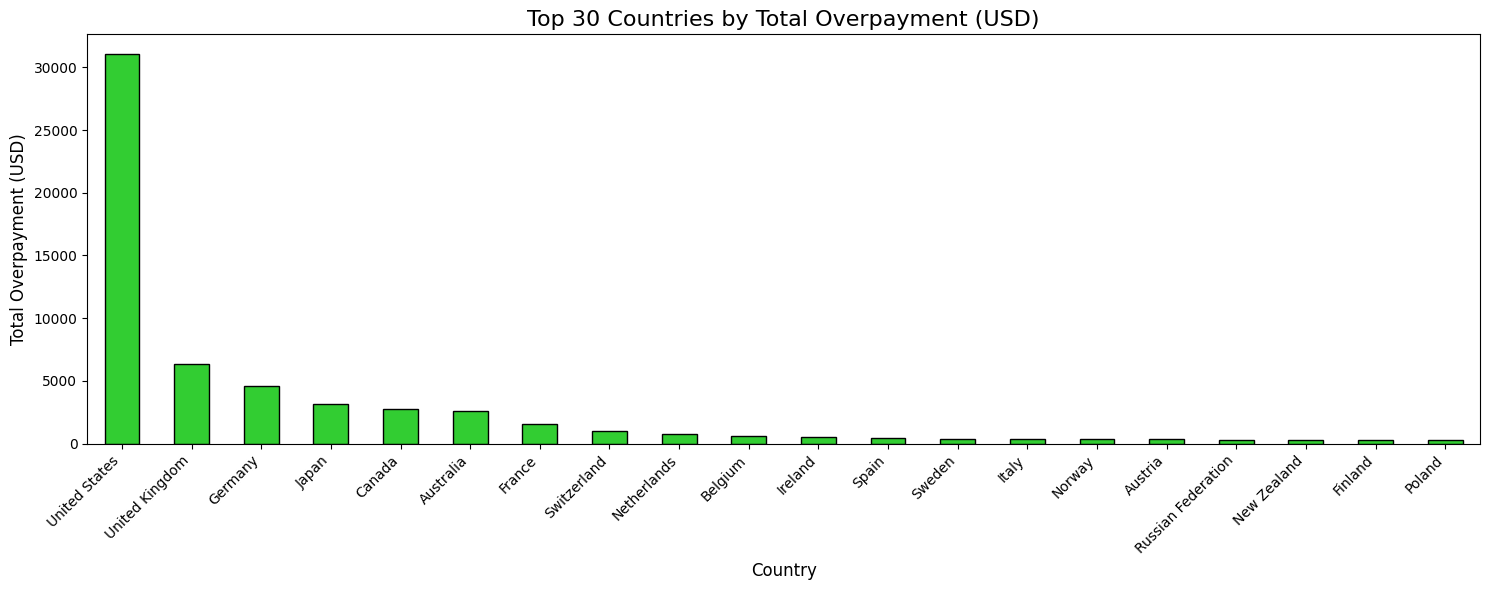

In [118]:
# Group by country and sum the overpayment_usd
overpayment_by_country = over_case_11.groupby("country")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_country.plot(kind='bar', color='limegreen', edgecolor='black')

# Add labels and title
plt.title('Top 30 Countries by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

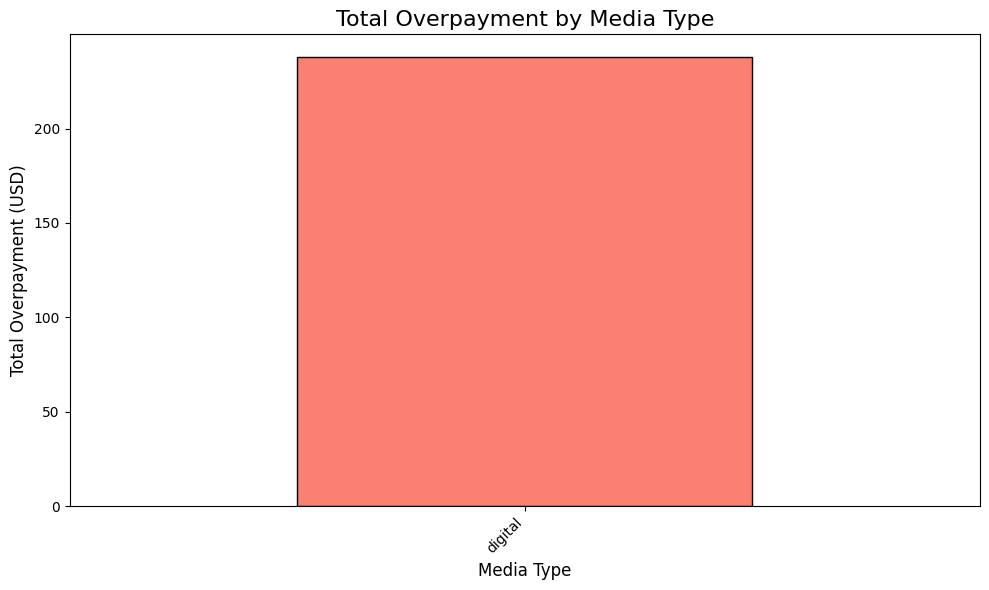

In [119]:
# Group by media type and sum the overpayment
overpayment_by_media_type = over_case_13.groupby("media_type")["overpayment_usd"].sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
overpayment_by_media_type.plot(kind='bar', color='salmon', edgecolor='black')

# Add labels and title
plt.title('Total Overpayment by Media Type', fontsize=16)
plt.xlabel('Media Type', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

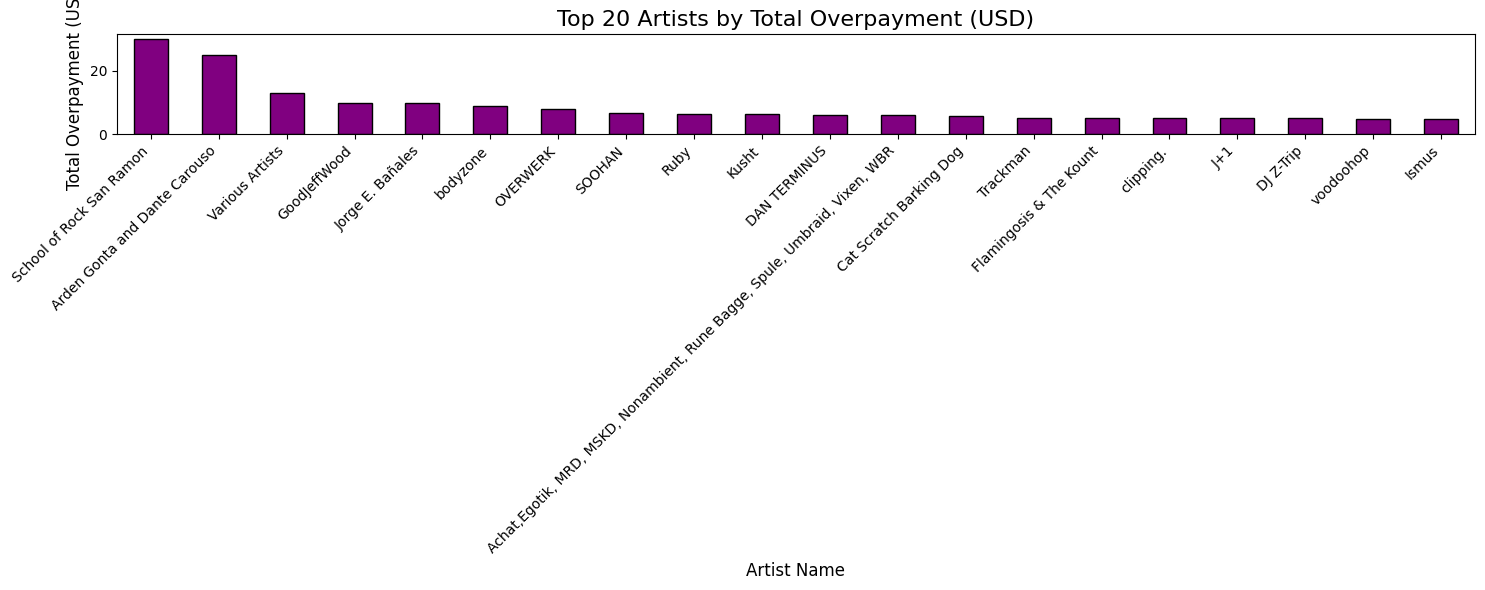

In [120]:
# Group by artist_name and sum the overpayment_usd
overpayment_by_artist = over_case_13.groupby("artist_name")["overpayment_usd"].sum().sort_values(ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(15, 6))
overpayment_by_artist.plot(kind='bar', color='purple', edgecolor='black')

# Add labels and title
plt.title('Top 20 Artists by Total Overpayment (USD)', fontsize=16)
plt.xlabel('Artist Name', fontsize=12)
plt.ylabel('Total Overpayment (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

School of Rock San Ramon - is actually a school.


In [121]:
# Calculate the difference
over_case_13["overpayment_difference"] = over_case_13["overpayment_usd"] - over_case_13["amount_over_usd"]

# Sort by the difference in descending order
over_case_13 = over_case_13.sort_values(by="overpayment_difference", ascending=False)

# Display the result
over_case_13[["overpayment_usd", "amount_over_usd", "overpayment_difference"]].head(15)

,overpayment_usd,amount_over_usd,overpayment_difference
851832,12.9008,1.7592,11.1416
850450,15.0000,5.0000,10.0000
850451,15.0000,5.0000,10.0000
396890,9.0000,3.0000,6.0000
128200,5.9200,1.4800,4.4400
469697,5.6400,1.8800,3.7600
100901,6.6600,3.3300,3.3300
742591,3.8400,1.2800,2.5600
741490,5.1000,2.5500,2.5500
599833,5.0000,2.5000,2.5000


In [122]:
total_overpayment = over_case_13["overpayment_usd"].sum()
print(f"Total overpayment (USD) for over_case_13: {total_overpayment}")

Total overpayment (USD) for over_case_13: 238.06346666666744


In [123]:
total_overpayment_by_country = over_case_13.groupby("country")["overpayment_usd"].sum().round(2).sort_values(ascending=False)
print(total_overpayment_by_country)

country
United States         155.54
Germany                17.13
United Kingdom         11.81
Canada                 10.02
Switzerland             9.60
Russian Federation      8.00
Japan                   6.87
Brazil                  5.92
Poland                  3.84
France                  3.51
Portugal                3.49
Denmark                 2.33
Romania                 0.00
Australia               0.00
Norway                  0.00
New Zealand             0.00
Netherlands             0.00
Slovakia                0.00
Serbia                  0.00
Malta                   0.00
Slovenia                0.00
South Africa            0.00
Spain                   0.00
Sweden                  0.00
Thailand                0.00
Mexico                  0.00
Italy                   0.00
Luxembourg              0.00
Lithuania               0.00
Belarus                 0.00
Belgium                 0.00
Bulgaria                0.00
C2                      0.00
Chile                   0.00
Costa 

#### BACKUP CHECKPOINT

In [124]:
# save backup
df_filename = 'bandcamp-sales-v07-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v07-eda.pkl


In [125]:
# restore backup
df_filename = 'bandcamp-sales-v07-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,country_code,country,amount_paid_fmt,item_price,amount_paid,releases,artist_name,currency,album_title,amount_paid_usd,amount_over_fmt,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle,conversion_rate,amount_over_usd,item_price_usd,paid_usd_delta,overpayment_usd,underpayment_usd
0,gb,United Kingdom,$9.99,9.99,9.99,NaN,Girl Band,USD,NaN,9.99,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.00,0.0,9.99,2.288818e-07,2.288818e-07,0.000000e+00
1,fi,Finland,£1,1.00,1.00,NaN,Jirah,GBP,NaN,1.30,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.30,0.0,1.30,0.000000e+00,0.000000e+00,0.000000e+00
2,fi,Finland,£3,3.00,3.00,NaN,D-Ther,GBP,NaN,3.90,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,1.30,0.0,3.90,-4.440892e-16,0.000000e+00,4.440892e-16
3,gb,United Kingdom,€10.50,10.50,10.50,NaN,WHITE NOISE TV,EUR,WHITE NOISE TV,12.39,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,CD,no details,0,other,0,1.18,0.0,12.39,-1.776357e-15,0.000000e+00,1.776357e-15
4,us,United States,$1,1.00,1.00,NaN,LINGUA IGNOTA,USD,NaN,1.00,0.0,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0,other,0,1.00,0.0,1.00,0.000000e+00,0.000000e+00,0.000000e+00


#### Conclusions on overpayment and donations.

- TBD later

## Preparing payment related features for modeling

*Action plan:*
- Finalysing two target columns: 
  - Main Target: `amount_paid_usd` - to predict total payment.
  - Extra target: `is_donation` - to predict volunterly contribution.
- Changing columns:
  - `discount`: rename `Underpaymnet`, make sure 0 for no discount case.
  - `is_donation`: new column.
- For main target - only regressor model(s):
  - Keep all rows.
  - Remove features that are directly predicting my target:
    - `overpayment`, `is_donation`.
  - Keep features:
    - `item_price`, `amount_over`, `discount`.
  - Revisit this feature selection after training model.
- For extra target - only calssificator model(s):
  - New column `is_donation` with values 0 or 1.
  - What to consider as donation case true / false from `overpayment` and `amount over`?
    - Rule: `amount_over_usd` > 0 OR `overpayment` > 0.
  - Create subset for all rows.
  - Do not include features that directly set the donation flag in the train subdset:
    - `amount_over_usd`, `overpayment`, `amount_paid`.
  - Keep `item_price`, `discount`. Corellated, but not directly.
- Drop irrelevant columns:
  - foreign currency related, keep only `_usd` columns.

#### Treat underpayment as discount

In [126]:
df.columns

Index(['country_code', 'country', 'amount_paid_fmt', 'item_price',
       'amount_paid', 'releases', 'artist_name', 'currency', 'album_title',
       'amount_paid_usd', 'amount_over_fmt', 'hour', 'dayofweek', 'month',
       'year', 'weekday', 'weekend', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'media_type',
       'media_type_details', 'discography_size', 'merch_type', 'is_bundle',
       'conversion_rate', 'amount_over_usd', 'item_price_usd',
       'paid_usd_delta', 'overpayment_usd', 'underpayment_usd'],
      dtype='object')

In [127]:
df[["underpayment_usd"]].describe().T

,count,mean,std,min,25%,50%,75%,max
underpayment_usd,1000000.0,0.038486,1.092894,0.0,0.0,0.0,0.0,384.75


In [128]:
df.rename(columns={"underpayment_usd": "discount_usd"}, inplace=True)
df[["discount_usd"]].describe().T

,count,mean,std,min,25%,50%,75%,max
discount_usd,1000000.0,0.038486,1.092894,0.0,0.0,0.0,0.0,384.75


In [129]:
# Check for NaN and null values in the discount_usd column
nan_count = df["discount_usd"].isna().sum()
null_count = df["discount_usd"].isnull().sum()

print(f"NaN values in discount_usd: {nan_count}")
print(f"Null values in discount_usd: {null_count}")

NaN values in discount_usd: 0
Null values in discount_usd: 0


In [130]:
# track column name changes
columns_money.append("discount_usd")
columns_money.remove("underpayment_usd")

#### Create is_donation column

In [131]:
# Create the `is_donation` column based on the given rule
df['is_donation'] = ((df['amount_over_usd'] > 0) | (df['overpayment_usd'] > 0)).astype(int)

# Verify the new column
df[['amount_over_usd', 'overpayment_usd', 'is_donation']].round(4).sample(5)

,amount_over_usd,overpayment_usd,is_donation
400898,0.0,1.19,1
508550,0.0,0.00,0
435127,3.0,0.00,1
245744,0.0,0.00,0
321294,0.0,0.00,0


In [132]:
# track new column
columns_money.append("is_donation")

### Drop columns related to foreign currencies

In [133]:
df.columns

Index(['country_code', 'country', 'amount_paid_fmt', 'item_price',
       'amount_paid', 'releases', 'artist_name', 'currency', 'album_title',
       'amount_paid_usd', 'amount_over_fmt', 'hour', 'dayofweek', 'month',
       'year', 'weekday', 'weekend', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'media_type',
       'media_type_details', 'discography_size', 'merch_type', 'is_bundle',
       'conversion_rate', 'amount_over_usd', 'item_price_usd',
       'paid_usd_delta', 'overpayment_usd', 'discount_usd', 'is_donation'],
      dtype='object')

In [134]:
df[columns_money].columns

Index(['amount_paid', 'amount_paid_usd', 'item_price', 'item_price_usd',
       'amount_over_fmt', 'amount_over_usd', 'currency', 'conversion_rate',
       'amount_paid_fmt', 'paid_usd_delta', 'overpayment_usd', 'discount_usd',
       'is_donation'],
      dtype='object')

In [135]:
columns_to_drop = ["amount_over_fmt", "amount_paid_fmt", "amount_paid", "item_price", "currency", "conversion_rate", "paid_usd_delta"]
columns_money = [col for col in columns_money if col not in columns_to_drop]
df.drop(columns=columns_to_drop, inplace=True)
df[columns_money].columns

Index(['amount_paid_usd', 'item_price_usd', 'amount_over_usd',
       'overpayment_usd', 'discount_usd', 'is_donation'],
      dtype='object')

#### BACKUP CHECKPOINT

In [136]:
# save backup
df_filename = 'bandcamp-sales-v08-eda'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v08-eda.pkl


In [137]:
# restore backup
df_filename = 'bandcamp-sales-v08-eda'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,country_code,country,releases,artist_name,album_title,amount_paid_usd,hour,dayofweek,month,year,weekday,weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,media_type,media_type_details,discography_size,merch_type,is_bundle,amount_over_usd,item_price_usd,overpayment_usd,discount_usd,is_donation
0,gb,United Kingdom,NaN,Girl Band,NaN,9.99,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,0.0,9.99,2.288818e-07,0.000000e+00,1
1,fi,Finland,NaN,Jirah,NaN,1.30,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,0.0,1.30,0.000000e+00,0.000000e+00,0
2,fi,Finland,NaN,D-Ther,NaN,3.90,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,album,0,other,0,0.0,3.90,0.000000e+00,4.440892e-16,0
3,gb,United Kingdom,NaN,WHITE NOISE TV,WHITE NOISE TV,12.39,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,CD,no details,0,other,0,0.0,12.39,0.000000e+00,1.776357e-15,0
4,us,United States,NaN,LINGUA IGNOTA,NaN,1.00,22,2,9,2020,2,False,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,digital,single,0,other,0,0.0,1.00,0.000000e+00,0.000000e+00,0


# Treating absence of data

In [138]:
df_nulls = eda.count_nulls(df)
print(df_nulls)

                     is_na   not_na  na_percent na_percent_pretty
releases            988416    11584     98.8416            98.84%
album_title         643539   356461     64.3539            64.35%
artist_name             10   999990      0.0010             0.00%
country_code             0  1000000      0.0000             0.00%
country                  0  1000000      0.0000             0.00%
amount_paid_usd          0  1000000      0.0000             0.00%
hour                     0  1000000      0.0000             0.00%
dayofweek                0  1000000      0.0000             0.00%
month                    0  1000000      0.0000             0.00%
year                     0  1000000      0.0000             0.00%
weekday                  0  1000000      0.0000             0.00%
weekend                  0  1000000      0.0000             0.00%
hour_sin                 0  1000000      0.0000             0.00%
hour_cos                 0  1000000      0.0000             0.00%
weekday_si

In [139]:
releases_df = df[["releases", "album_title"]]
eda.print_eda_report(releases_df)


================= Dataset =================
Dataset has shape (1000000, 2)

Dataset has numerical data in columns: ['releases']
- Column "releases" has 220 unique values.

Dataset has categorical data in columns: ['album_title']
- Column "album_title" has 103697 unique values.



In [140]:
releases_df["releases"].sort_values()

852707    3.0
187180    3.0
732190    3.0
453187    3.0
556810    3.0
         ... 
999995    NaN
999996    NaN
999997    NaN
999998    NaN
999999    NaN
Name: releases, Length: 1000000, dtype: float64

In [141]:
columns_to_drop = ["releases", "album_title"]
df.drop(columns=columns_to_drop, inplace=True)

In [142]:
df["artist_name"].fillna("unknown artist", inplace=True)

In [143]:
df_nulls = eda.count_nulls(df)
print(df_nulls)

                    is_na   not_na  na_percent na_percent_pretty
country_code            0  1000000         0.0             0.00%
country                 0  1000000         0.0             0.00%
artist_name             0  1000000         0.0             0.00%
amount_paid_usd         0  1000000         0.0             0.00%
hour                    0  1000000         0.0             0.00%
dayofweek               0  1000000         0.0             0.00%
month                   0  1000000         0.0             0.00%
year                    0  1000000         0.0             0.00%
weekday                 0  1000000         0.0             0.00%
weekend                 0  1000000         0.0             0.00%
hour_sin                0  1000000         0.0             0.00%
hour_cos                0  1000000         0.0             0.00%
weekday_sin             0  1000000         0.0             0.00%
weekday_cos             0  1000000         0.0             0.00%
month_sin               0

# Backup dataframe

In [144]:
df_filename = 'bandcamp-sales-v1-cleaned'
fl.save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/data/bandcamp-sales-v1-cleaned.pkl
